In [57]:
from HeaderP import *

In [58]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection


In [59]:
# from So
colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
import requests
def download_ztf_archive_lightcurves(ra, dec, objids=[], sr=0.001, lcout=False):
    ra = str(ra)
    dec = str(dec)
    url1 = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE "
    url2 = f"{ra} {dec} {sr}&BANDNAME=r&NOBS_MIN=30&BAD_CATFLAGS_MASK=32768&FORMAT=ipac_table"
    url = url1 + url2
    r = requests.get(url)
    f = open(f"./lc/ra_{ra}_dec_{dec}", "wb")
    f.write(r.content)  # save to file
 
    mainlc = pd.read_table(f"./lc/ra_{ra}_dec_{dec}",
                          delim_whitespace=True, skiprows=54, names=colnames)
    if len(mainlc)==0:
        os.remove(f"./lc/ra_{ra}_dec_{dec}")
        return objids
    else:
        ojid_sing = mainlc['oid'].values[0]
        
    if ojid_sing in objids:
        os.remove(f"./lc/ra_{ra}_dec_{dec}")
    else:
        objids.append(ojid_sing)
        
    if lcout:
        return mainlc
    else:
        return objids
    

In [60]:
data = pd.read_pickle('gaia_obsnumb_absg7.pkl')
gaiadata = pd.read_pickle('gaia_color_greater1.pkl')


In [61]:
data.columns

Index(['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'gmag', 'bp_rp',
       'pmra', 'pmdec', 'dr2_radial_velocity', 'dr2_radial_velocity_error',
       'ruwe', 'abs_G', 'ZTFobsNumb', 'ZTF_g_lc_Numb', 'ZTF_r_lc_Numb',
       'ZTF_i_lc_Numb'],
      dtype='object')

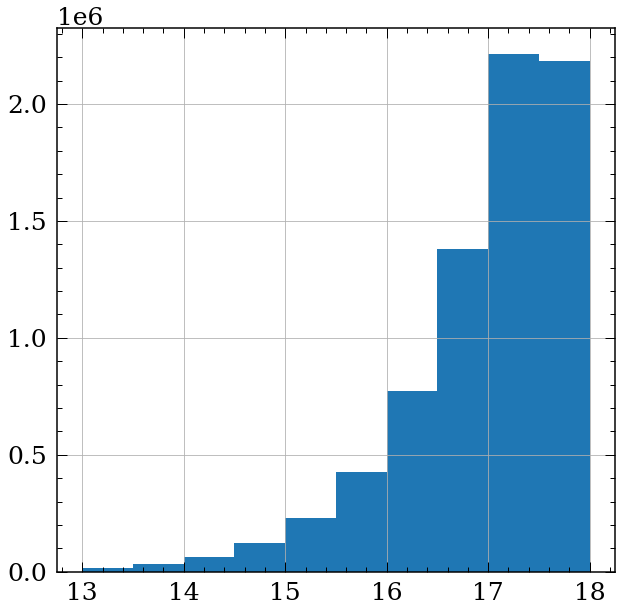

In [62]:
data['gmag'].hist()
data = data.loc[data['gmag']<18].reset_index(drop=True)


In [63]:
np.shape(data)

(7439582, 17)

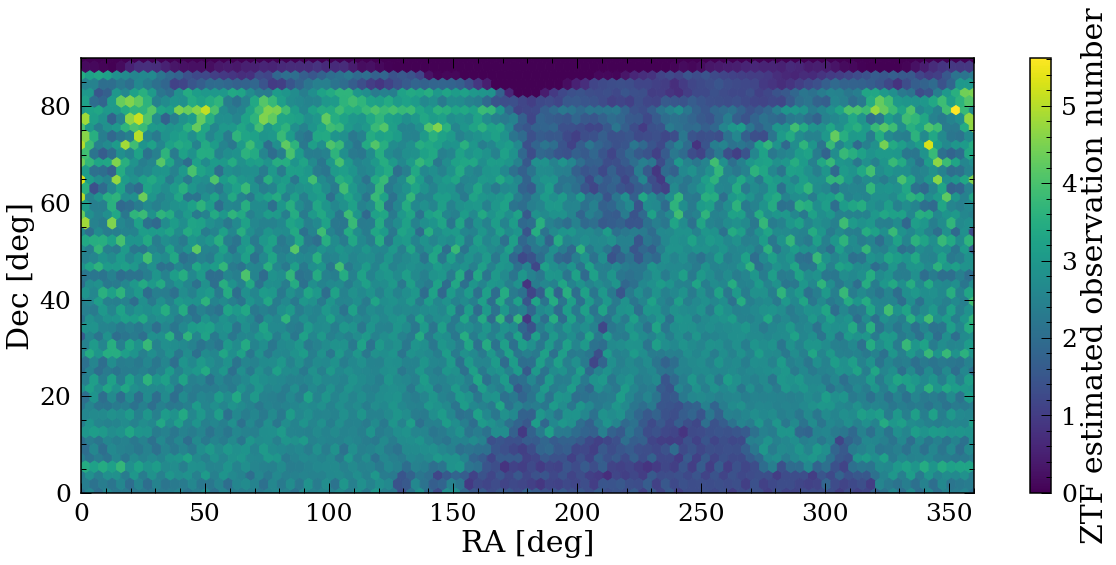

In [64]:
fig, ax = plt.subplots(figsize=(20,8))
plt.hexbin(data['ra'], data['dec'], C = data['ZTF_r_lc_Numb'], extent = (0,360,0,90), gridsize=(100, 25))
plt.xlim([0, 360])
plt.ylim([0, 90])
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
cb = plt.colorbar()
cb.set_label('ZTF estimated observation number')

462


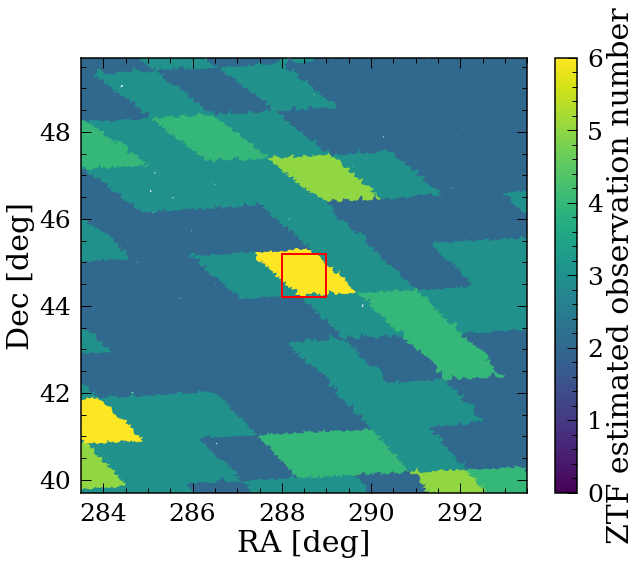

In [65]:
# check a small patch
xcenter, ycenter = 288.5, 44.7
boxsize = 1


fig, ax = plt.subplots(figsize=(10,8))
m_plt =(abs(data['ra']-xcenter)<5*boxsize)&(abs(data['dec']-ycenter)<5*boxsize).values
data_plt = data.loc[m_plt].reset_index(drop=True)
plt.scatter(data_plt['ra'], data_plt['dec'], c = data_plt['ZTF_r_lc_Numb'], vmin = 0, vmax=6)
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim([xcenter-5*boxsize,xcenter+5*boxsize])
plt.ylim([ycenter-5*boxsize,ycenter+5*boxsize])
cb = plt.colorbar()
cb.set_label('ZTF estimated observation number')
selbox = Rectangle((xcenter - boxsize/2, ycenter - boxsize/2), boxsize, boxsize, edgecolor = 'r',
                  fill=None, linewidth=2)
ax.add_patch(selbox)

m =(abs(data['ra']-xcenter)<boxsize/2)&(abs(data['dec']-ycenter)<boxsize/2).values
data_subset = data.loc[m].reset_index(drop=True)
"""
plt.scatter(data_subset['ra'], data_subset['dec'], c = data_subset['ZTF_r_lc_Numb'], edgecolor='r',
           vmin = 0, vmax=6)
"""
print(len(data_subset))

In [66]:
ras = data_subset['ra'].values
decs = data_subset['dec'].values
print(np.shape(ras))

(462,)


In [159]:
import io
import os
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

def fitpoly(t,mag):
    p = fitpoints(t,mag,2)
    return t, mag-p(t)



def movingMed_time(t, mag, T_window,delta_T_window):
    # add in two columns for the median and put Nan's in them
    t_med=np.empty(len(mag))
    mag_med=np.empty(len(mag))
    t_med[:]=np.nan
    mag_med[:]=np.nan
    
    # define the boundaries of the windows
    window_min=float(min(t))
    window_max=float(window_min+delta_T_window)
    # max time
    maxtime=max(t)
    # break when time window hits the end
    while window_max<=maxtime+T_window:
        seldf=((t>=window_min) & (t<=window_max)) # get points between the window
        
        t_med[seldf]=np.median(t[seldf]) # all values for these indices are subsituded with median time
        mag_med[seldf]=np.median(mag[seldf]) # all values for these indices are subsituded with median flux

        window_min=window_min+delta_T_window
        window_max=window_max+delta_T_window
    return t_med, mag_med



def processlc(maincord, searchradius=5, magrange=1, pltorg=False, timewindow=[]):
    # search radius is arcmin
    colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
    
    mainlc = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=0.0003, lcout=True)
    lcs = download_ztf_archive_lightcurves(maincord[0], maincord[1], sr=searchradius/60, lcout=True)
    nearlcs = lcs.loc[~lcs['oid'].isin(mainlc['oid'].unique())].reset_index(drop=True)
    m = abs(nearlcs['mag']-np.median(mainlc['mag']))<magrange
    nearlcs = nearlcs[m].reset_index(drop=True)
    nearlc_ids = nearlcs['oid'].unique()
    nearbylcs_no = len(nearlc_ids)
    print('There are nearby %d lcs...'%(nearbylcs_no))
    
    mags = nearlcs['mag']
    for i in trange(nearbylcs_no):
        m = (nearlcs['oid'] == nearlc_ids[i])
        mags[m] = mags[m]/np.median(mags[m])
        
    nearlcs['mag'] = mags
    
    
    lctime = mainlc['mjd'].values-min(mainlc['mjd'].values)
    lcmags = mainlc['mag'].values
    lcmags_err = mainlc['magerr'].values
    
    if len(timewindow)>0:
        mmm = abs(lctime-sum(timewindow)/2)<abs(timewindow[1]-timewindow[0])/2
        lctime = lctime[mmm]
        lcmags = lcmags[mmm]
        lcmags_err = lcmags_err[mmm]
    
    
    if pltorg:
        print('LG orginal lcs...')
        plt.figure(figsize=(30,8))
        plt.subplot(1,3,1)
        plt.plot(lctime, lcmags, 'r.', markersize=5, label='pre process')
        plt.xlabel('Time [days]')
        plt.ylabel('Magnitude')
        plt.ylim([min(lcmags),max(lcmags)])
        #plt.ylim([0.5*np.median(lcmags), 1.5*np.median(lcmags)])
        plt.gca().invert_yaxis()
        plt.title('Origenal lc',fontsize=25)
        
        prots = np.linspace(1,300,500)*u.day
        frequency = 1/prots
        power = LombScargle(lctime * u.day, lcmags * u.mag, 
                                       lcmags_err * u.mag).power(frequency)
        ls_2 = LombScargle(lctime * u.day, lcmags * u.mag, lcmags_err * u.mag)

        best_frequency = frequency[np.argmax(power)]
        y_fit = ls_2.model(lctime * u.day, best_frequency)

        
        plt.subplot(1,3,2)
        P = 1/best_frequency
        t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P.value)*P.value
        plt.plot(t_fold,  lcmags, 'k.')   
        t_fold, mag = zip(*sorted(zip(t_fold, lcmags)))
        mag_fit = ls_2.model(t_fold * u.day, best_frequency)
        #plt.plot(t_fold, mag_fit, 'r--')
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.tight_layout()
        plt.ylim([min(lcmags),max(lcmags)])
        plt.title('Prot = %.2f days'%(P.value), fontsize=25)
        plt.gca().invert_yaxis()
        
        plt.subplot(1,3,3)
        plt.plot(1/frequency, power, 'k-')   
        plt.xlim(1,300)
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.ylim([0,max(power)])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()
    

    lcmags = lcmags/np.median(lcmags)
    lcmags_err = lcmags_err/np.median(lcmags)
     
    nearlc_time = nearlcs['mjd'].values-min(mainlc['mjd'].values)
    nearlc_mag = nearlcs['mag'].values
    
    lcmags_new = np.zeros(len(lctime))
    for i in range(len(lctime)):
        m = (nearlc_time == lctime[i])
        lcmags_new[i] = lcmags[i]-np.median(nearlc_mag[m])
    
    medt, medmag = movingMed_time(lctime, lcmags_new, 1, 3)
    #print(len(lcmags_new), len(medmag), len(lcmags_err))
    good_ind = abs(lcmags_new-medmag)/lcmags_err<3.5
    lctime, lcmags, lcmags_new, lcmags_err = lctime[good_ind], lcmags[good_ind], lcmags_new[good_ind], lcmags_err[good_ind]
    
    if pltorg:
        print('LG post processed lcs...')
        plt.figure(figsize=(30,8))
        plt.subplot(1,3,1)
        plt.plot(lctime, lcmags_new, 'r.', markersize=5, label='post process')
        plt.xlabel('Time [days]')
        plt.ylabel('normaized magnitude (post)')
        plt.ylim([min(lcmags_new),max(lcmags_new)])
        plt.gca().invert_yaxis()
        plt.title('Processed lc',fontsize=25)
        
        prots = np.linspace(1,300,500)*u.day
        frequency = 1/prots
        power = LombScargle(lctime * u.day, lcmags_new * u.mag, 
                            lcmags_err* u.mag).power(frequency)
        ls_2 = LombScargle(lctime * u.day, lcmags_new * u.mag, lcmags_err* u.mag)

        best_frequency = frequency[np.argmax(power)]
        y_fit = ls_2.model(lctime * u.day, best_frequency)
        
        plt.subplot(1,3,2)
        P = 1/best_frequency
        t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P.value)*P.value
        plt.plot(t_fold,  lcmags_new, 'k.')   
        t_fold, mag = zip(*sorted(zip(t_fold, lcmags_new)))
        mag_fit = ls_2.model(t_fold * u.day, best_frequency)
        #plt.plot(t_fold, mag_fit, 'r--')
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.tight_layout()
        plt.ylim([min(lcmags_new),max(lcmags_new)])
        plt.title('Prot = %.2f days'%(P.value), fontsize=25)
        plt.gca().invert_yaxis()
        
        plt.subplot(1,3,3)
        plt.plot(1/frequency, power, 'k-')   
        plt.xlim(1,300)
        plt.xlabel('Period [Day]')
        plt.ylabel('Power')
        plt.ylim([0,max(power)])
        plt.title('(ra, dec) = ('+str(maincord[0])+', '+str(maincord[1])+')',fontsize=25)
        plt.tight_layout()
    else:
        prots = np.linspace(1,300,500)*u.day
        frequency = 1/prots
        power = LombScargle(lctime * u.day, lcmags_new * u.mag, 
                                       lcmags_err* u.mag).power(frequency)
        ls_2 = LombScargle(lctime * u.day, lcmags_new * u.mag, lcmags_err* u.mag)

        best_frequency = frequency[np.argmax(power)]
        P = 1/best_frequency
    
    return lctime, lcmags, P.value, max(power)
    
        
        
    


In [50]:
lc = download_ztf_archive_lightcurves(132.10362330189, 20.70508518130, sr=0.0003, lcout=True)


0.002395899995462969

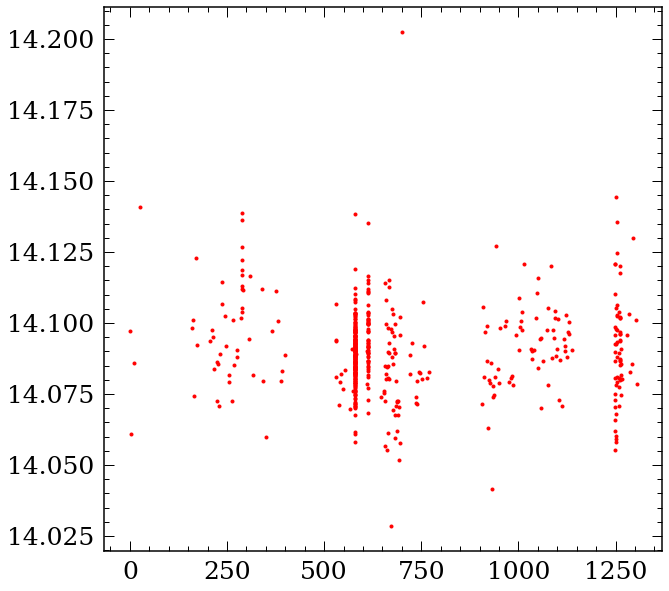

In [51]:
plt.plot(lc['mjd']-np.min(lc['mjd']),lc['mag'],'r.')
np.median(np.diff(lc['mjd']))

There are nearby 55 lcs...


100%|██████████| 55/55 [00:00<00:00, 753.02it/s]

LG orginal lcs...


LG post processed lcs...


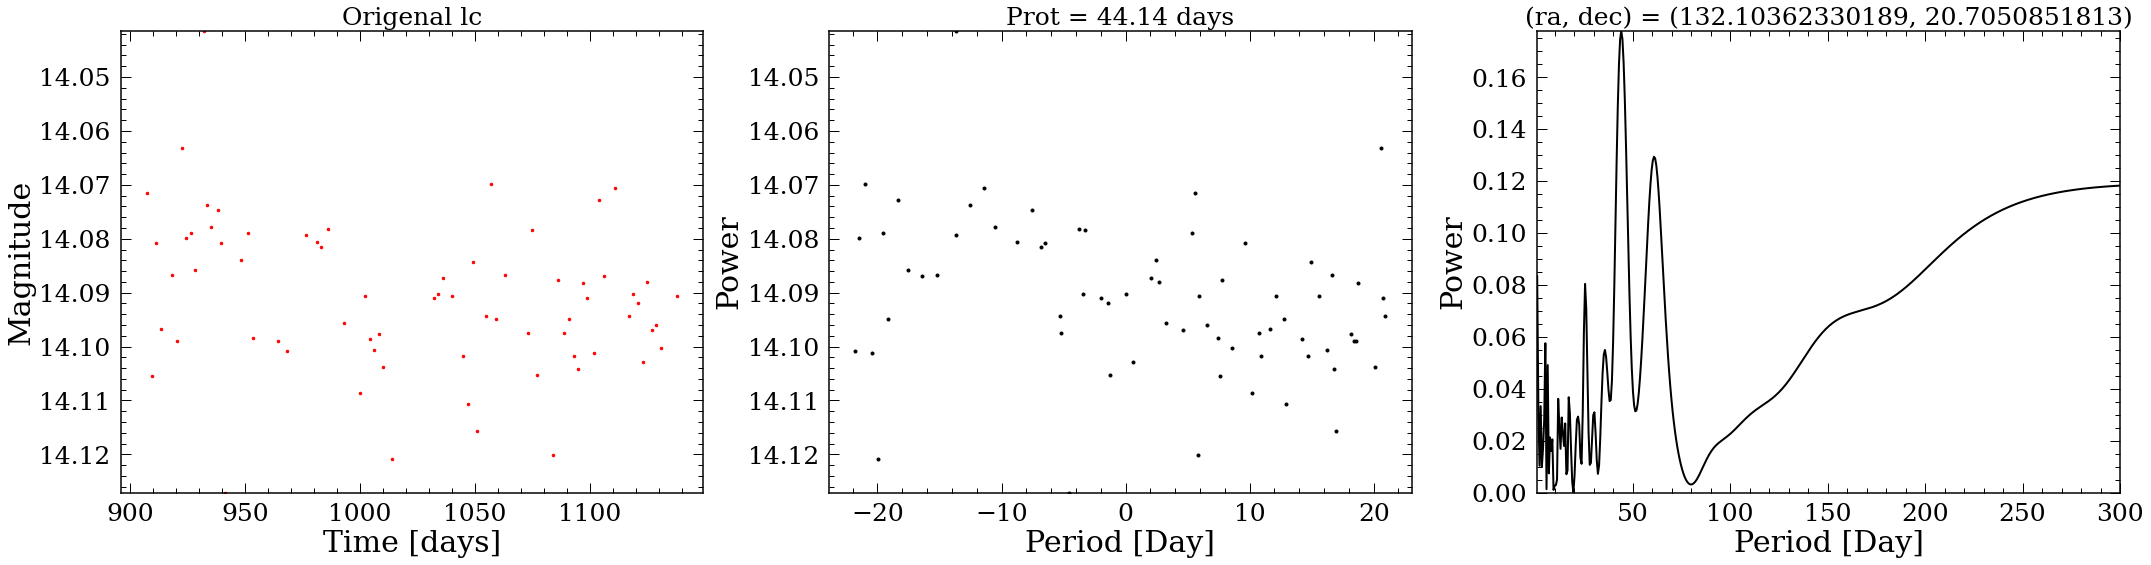

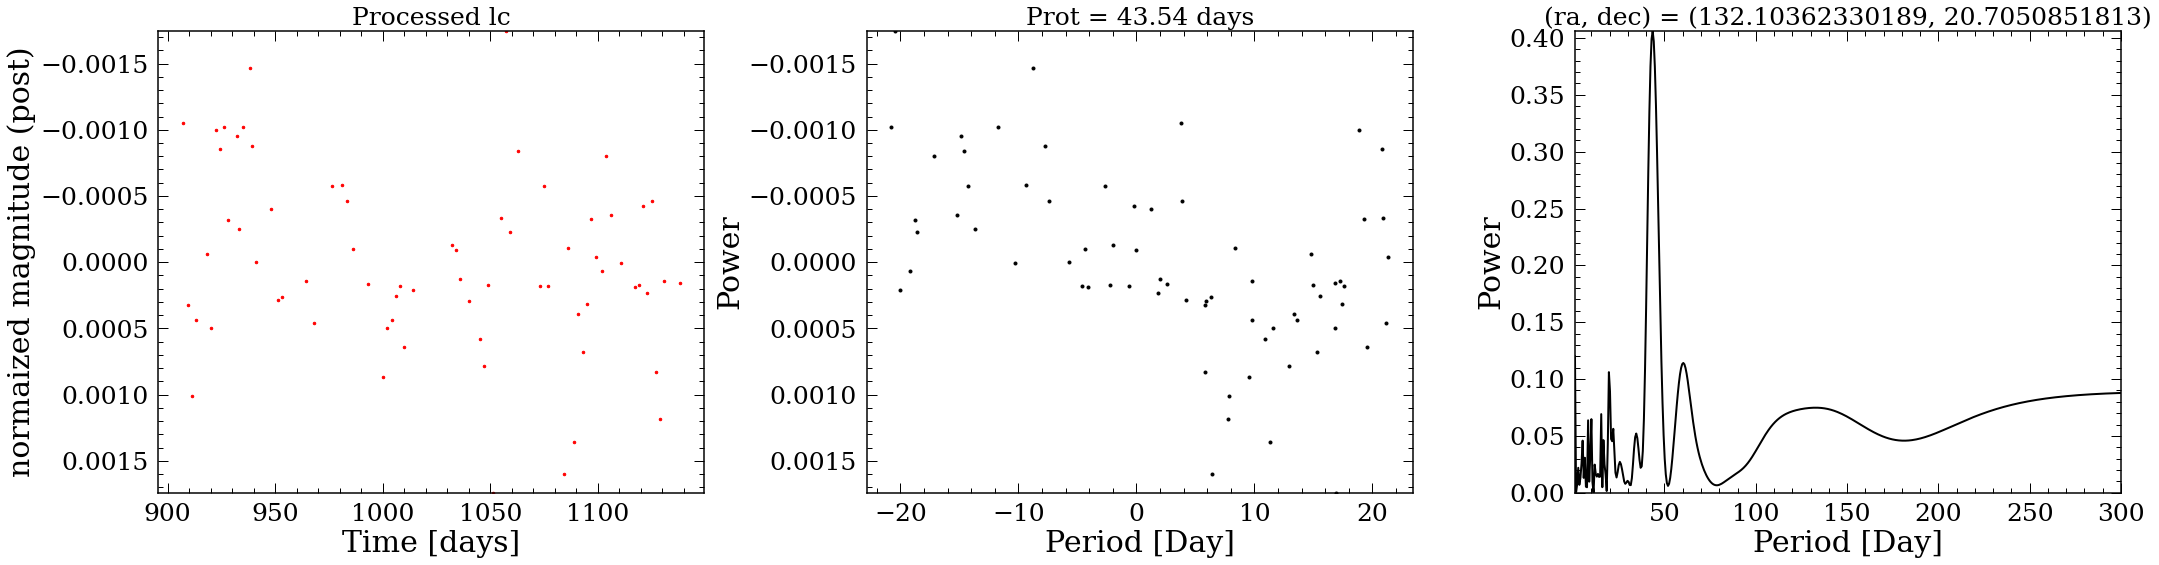

In [165]:

lctime, lcmags, p, maxpower = processlc([132.10362330189, 20.70508518130], 
          searchradius=4, magrange=4, pltorg=True, timewindow=[800,1200])


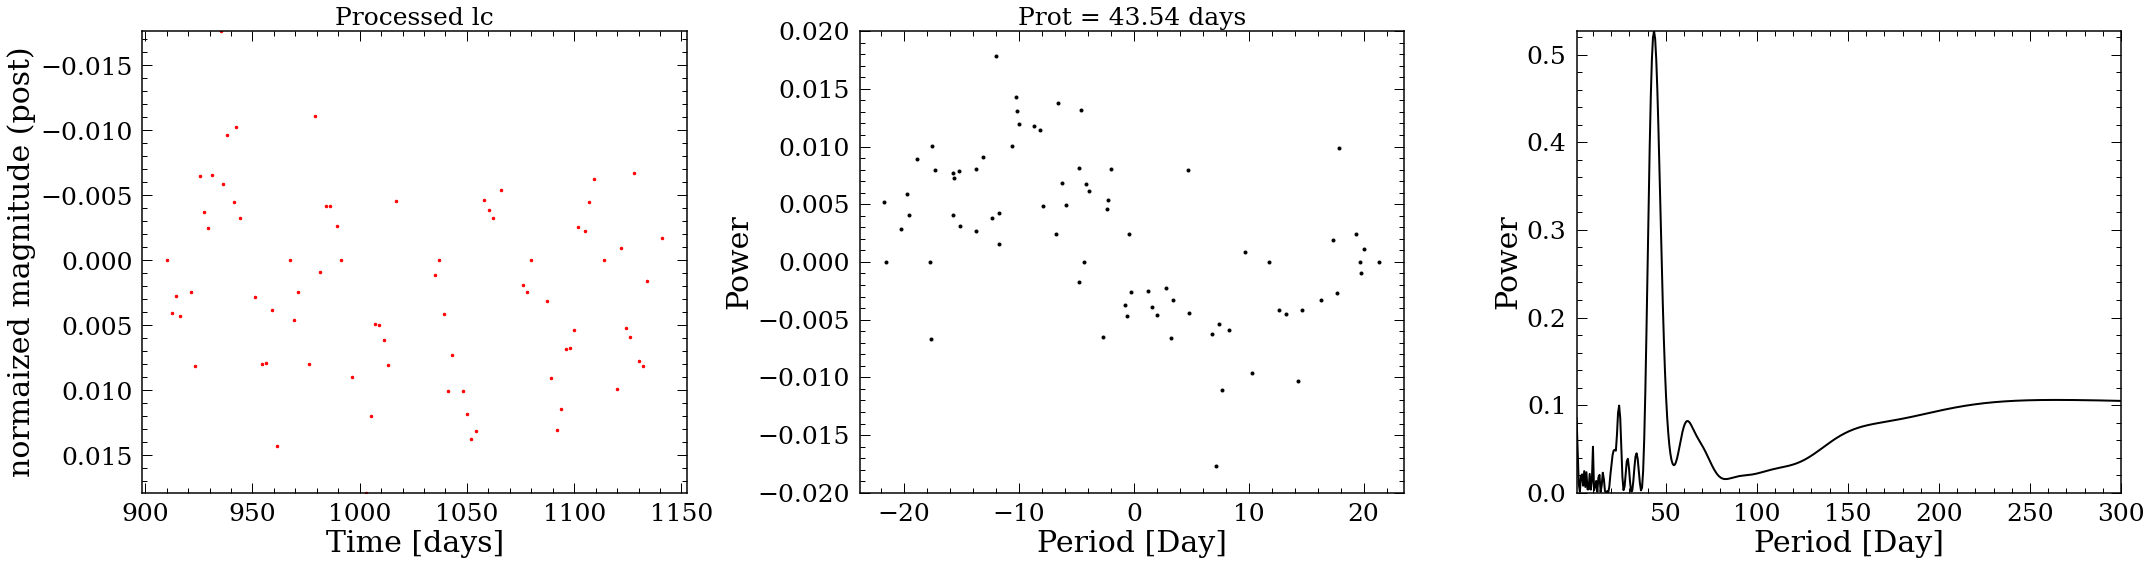

In [210]:
# compare to Jason's lc
jason_lc = pd.read_csv('Lucy-Gaia_EDR3-61794060190112000-ZTF_r.csv',names=['time','mag','filter'])
lctime = jason_lc['time'].values
lcmags_new = jason_lc['mag'].values

medt, medmag = movingMed_time(lctime, lcmags_new, 1, 3)
good_ind =(abs(lcmags_new-medmag)<0.1)
good_ind = good_ind&(abs(lctime-1000)<200)
lctime, lcmags_new = lctime[good_ind], lcmags_new[good_ind]
    
    
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.plot(lctime, lcmags_new, 'r.', markersize=5, label='post process')
plt.xlabel('Time [days]')
plt.ylabel('normaized magnitude (post)')
plt.ylim([min(lcmags_new),max(lcmags_new)])
plt.gca().invert_yaxis()
plt.title('Processed lc',fontsize=25)

prots = np.linspace(1,300,500)*u.day
frequency = 1/prots
power = LombScargle(lctime * u.day, lcmags_new * u.mag).power(frequency)
ls_2 = LombScargle(lctime * u.day, lcmags_new * u.mag)

best_frequency = frequency[np.argmax(power)]
y_fit = ls_2.model(lctime * u.day, best_frequency)

plt.subplot(1,3,2)
P = 1/best_frequency
t_fold=(lctime-np.median(lctime))-np.round((lctime-np.median(lctime))/P.value)*P.value
plt.plot(t_fold,  lcmags_new, 'k.')   
t_fold, mag = zip(*sorted(zip(t_fold, lcmags_new)))
mag_fit = ls_2.model(t_fold * u.day, best_frequency)
#plt.plot(t_fold, mag_fit, 'r--')
plt.xlabel('Period [Day]')
plt.ylabel('Power')
plt.tight_layout()
plt.ylim([min(lcmags_new),max(lcmags_new)])
plt.title('Prot = %.2f days'%(P.value), fontsize=25)
plt.ylim([-0.02,0.02])

plt.subplot(1,3,3)
plt.plot(1/frequency, power, 'k-')   
plt.xlim(1,300)
plt.xlabel('Period [Day]')
plt.ylabel('Power')
plt.ylim([0,max(power)])

plt.tight_layout()


There are nearby 55 lcs...


100%|██████████| 55/55 [00:00<00:00, 762.09it/s]

LG orginal lcs...


LG post processed lcs...


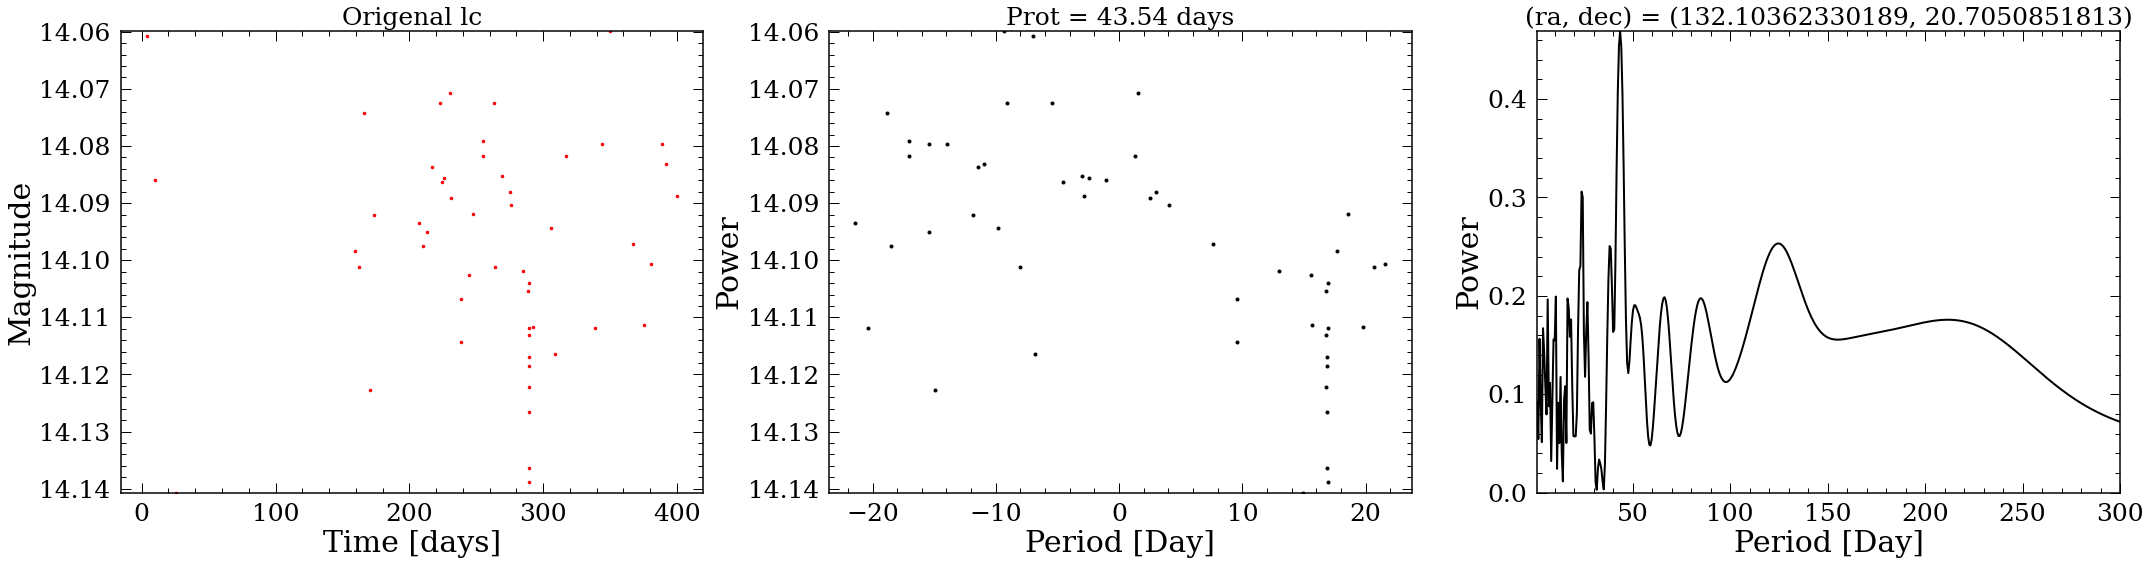

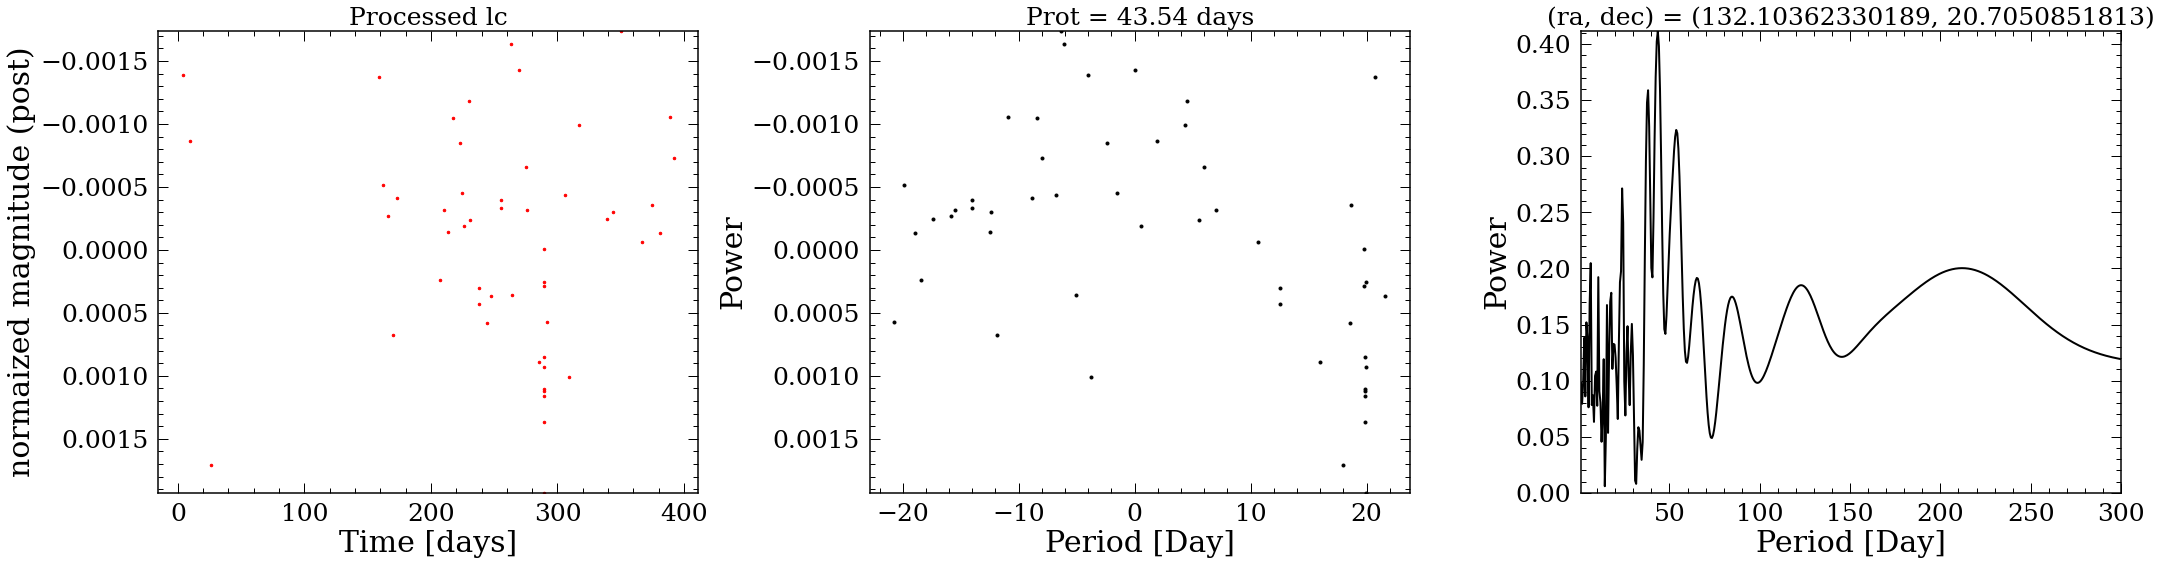

In [166]:

lctime, lcmags, p, maxpower = processlc([132.10362330189, 20.70508518130], 
          searchradius=4, magrange=4, pltorg=True, timewindow=[0,500])



In [167]:
search_r = np.linspace(3,7,5)
search_mag = np.linspace(0.1,5,5)

s_rs = []
s_mags = []
s_p = []
s_maxpower = []
for i in trange(len(search_r)):
    for j in search_mag: 
        lctime, lcmags, p, maxpower = processlc([132.10362330189, 20.70508518130], 
          searchradius=search_r[i], magrange=j, pltorg=False, timewindow=[0,500])
        s_rs.append(search_r[i])
        s_mags.append(j)
        s_p.append(p)
        s_maxpower.append(maxpower)

  0%|          | 0/5 [00:00<?, ?it/s]

There are nearby 1 lcs...



100%|██████████| 1/1 [00:00<00:00, 542.60it/s]


There are nearby 4 lcs...



100%|██████████| 4/4 [00:00<00:00, 590.66it/s]


There are nearby 13 lcs...



100%|██████████| 13/13 [00:00<00:00, 803.12it/s]


There are nearby 27 lcs...



100%|██████████| 27/27 [00:00<00:00, 741.11it/s]


There are nearby 57 lcs...



 20%|██        | 1/5 [03:45<15:02, 225.64s/it]

There are nearby 2 lcs...



100%|██████████| 2/2 [00:00<00:00, 507.60it/s]


There are nearby 9 lcs...



100%|██████████| 9/9 [00:00<00:00, 747.88it/s]


There are nearby 24 lcs...



100%|██████████| 24/24 [00:00<00:00, 790.99it/s]


There are nearby 46 lcs...



100%|██████████| 46/46 [00:00<00:00, 878.48it/s]


There are nearby 94 lcs...



 40%|████      | 2/5 [09:34<14:55, 298.40s/it]

There are nearby 2 lcs...



100%|██████████| 2/2 [00:00<00:00, 439.08it/s]


There are nearby 13 lcs...



100%|██████████| 13/13 [00:00<00:00, 406.64it/s]


There are nearby 40 lcs...



100%|██████████| 40/40 [00:00<00:00, 859.48it/s]


There are nearby 69 lcs...



100%|██████████| 69/69 [00:00<00:00, 720.97it/s]


There are nearby 136 lcs...



 60%|██████    | 3/5 [19:58<14:53, 446.73s/it]

There are nearby 3 lcs...



100%|██████████| 3/3 [00:00<00:00, 597.25it/s]


There are nearby 15 lcs...



100%|██████████| 15/15 [00:00<00:00, 791.14it/s]


There are nearby 49 lcs...



100%|██████████| 49/49 [00:00<00:00, 856.26it/s]


There are nearby 86 lcs...



100%|██████████| 86/86 [00:00<00:00, 739.76it/s]


There are nearby 169 lcs...



 80%|████████  | 4/5 [31:28<09:02, 542.91s/it]

There are nearby 3 lcs...



100%|██████████| 3/3 [00:00<00:00, 566.57it/s]


There are nearby 23 lcs...



100%|██████████| 23/23 [00:00<00:00, 613.07it/s]


There are nearby 63 lcs...



100%|██████████| 63/63 [00:00<00:00, 726.79it/s]


There are nearby 116 lcs...



100%|██████████| 116/116 [00:00<00:00, 753.11it/s][A


There are nearby 217 lcs...



100%|██████████| 5/5 [45:31<00:00, 546.39s/it]


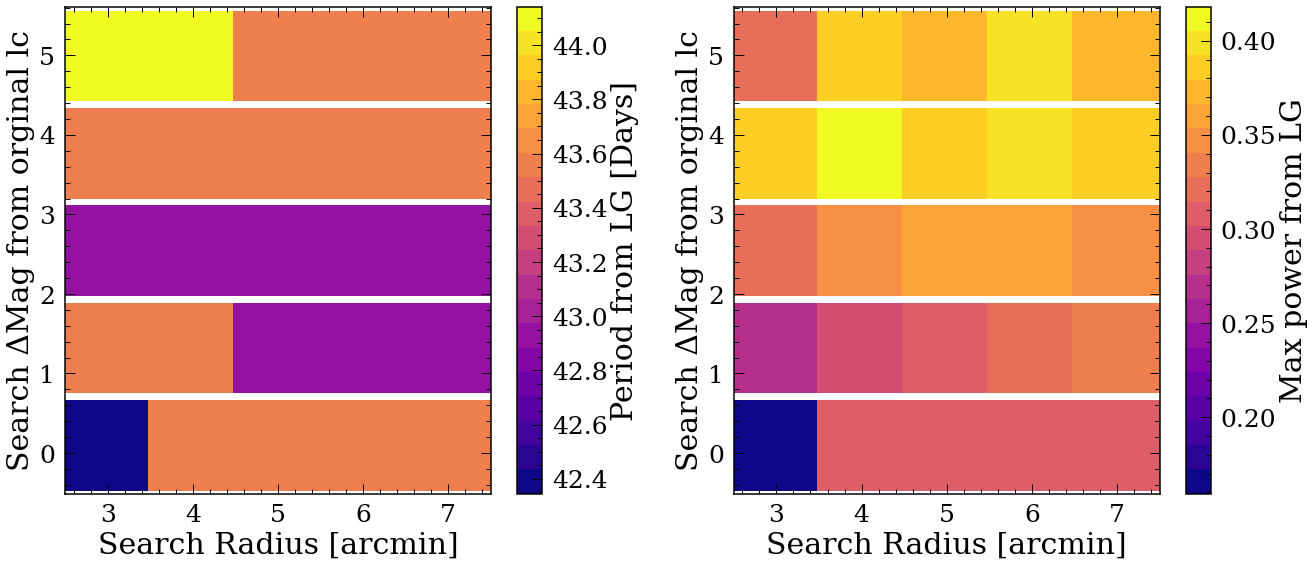

In [162]:
### 800-1200
cmap = plt.cm.get_cmap('plasma',20)
plt.figure(figsize=(18.5,8))
plt.subplot(1,2,1)
plt.scatter(np.array(s_rs), np.array(s_mags), c=np.array(s_p),cmap=cmap,marker='s',
           s=10000*4/len(search_r))
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔMag from orginal lc')
cb = plt.colorbar()
cb.set_label('Period from LG [Days]')
plt.xlim([min(search_r)-np.diff(search_r)[0]/2,
          max(search_r)+np.diff(search_r)[0]/2])
plt.ylim([min(search_mag)-np.diff(search_mag)[0]/2,
          max(search_mag)+np.diff(search_mag)[0]/2])

plt.subplot(1,2,2)
plt.scatter(np.array(s_rs), np.array(s_mags), c=np.array(s_maxpower),cmap=cmap,marker='s',
           s=10000*4/len(search_r))
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔMag from orginal lc')
cb = plt.colorbar()
cb.set_label('Max power from LG')
plt.xlim([min(search_r)-np.diff(search_r)[0]/2,
          max(search_r)+np.diff(search_r)[0]/2])
plt.ylim([min(search_mag)-np.diff(search_mag)[0]/2,
          max(search_mag)+np.diff(search_mag)[0]/2])

plt.tight_layout()

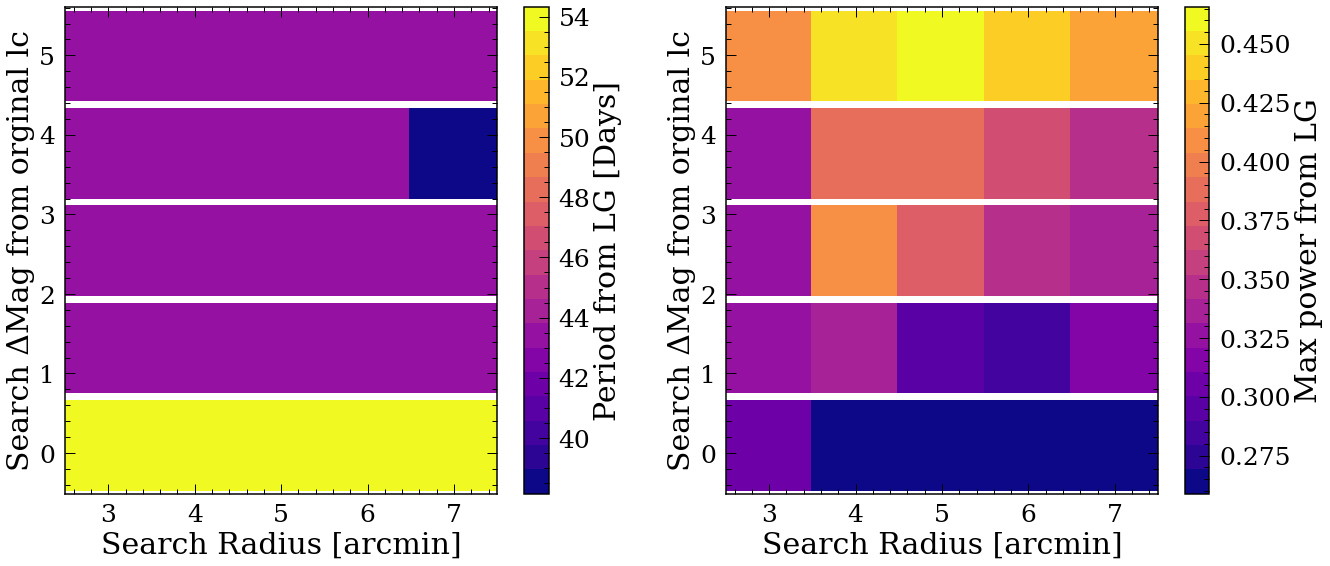

In [168]:
### 0-500
cmap = plt.cm.get_cmap('plasma',20)
plt.figure(figsize=(18.5,8))
plt.subplot(1,2,1)
plt.scatter(np.array(s_rs), np.array(s_mags), c=np.array(s_p),cmap=cmap,marker='s',
           s=10000*4/len(search_r))
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔMag from orginal lc')
cb = plt.colorbar()
cb.set_label('Period from LG [Days]')
plt.xlim([min(search_r)-np.diff(search_r)[0]/2,
          max(search_r)+np.diff(search_r)[0]/2])
plt.ylim([min(search_mag)-np.diff(search_mag)[0]/2,
          max(search_mag)+np.diff(search_mag)[0]/2])

plt.subplot(1,2,2)
plt.scatter(np.array(s_rs), np.array(s_mags), c=np.array(s_maxpower),cmap=cmap,marker='s',
           s=10000*4/len(search_r))
plt.xlabel('Search Radius [arcmin]')
plt.ylabel('Search ΔMag from orginal lc')
cb = plt.colorbar()
cb.set_label('Max power from LG')
plt.xlim([min(search_r)-np.diff(search_r)[0]/2,
          max(search_r)+np.diff(search_r)[0]/2])
plt.ylim([min(search_mag)-np.diff(search_mag)[0]/2,
          max(search_mag)+np.diff(search_mag)[0]/2])

plt.tight_layout()

# PCA

In [145]:
colnames = ['oid','expid','hjd','mjd','mag','magerr','catflags','filtercode',
                     'ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp',
                     'magzprms','clrcoeff','clrcounc','exptime','airmass','programid']
ilists=[]
for i in trange(100):
    if i == 0:
        mainlc = pd.read_table('./lc/ra_'+str(ras[0])+'_dec_'+str(decs[0]),
            delim_whitespace=True, skiprows=54, names=colnames)
        mainlc = mainlc.sort_values(by='mjd').reset_index(drop=True)
        mainlc['mag0'] = mainlc['mag']-np.median(mainlc['mag'])
        print(mainlc['oid'].values[0])
        ilists.append(i)
    else:
        try:
            mainlc_o = pd.read_table('./lc/ra_'+str(ras[i])+'_dec_'+str(decs[i]),
                delim_whitespace=True, skiprows=54, names=colnames)
        except:
            continue
        if len(mainlc_o)<500:
            continue
        ilists.append(i)
        mainlc_o = mainlc_o.sort_values(by='mjd').reset_index(drop=True)
        mainlc_o['mag'+str(i)] = mainlc_o['mag']-np.median(mainlc_o['mag'])
        mainlc=pd.merge(mainlc,mainlc_o[['mjd','mag'+str(i)]],
                        left_on='mjd', right_on='mjd', how='inner')
        print(mainlc_o['oid'].values[0])
        

 20%|██        | 20/100 [00:00<00:00, 96.97it/s]

766204200041459
766204100015935
766204200041251
766204200015598
766204200015389
766204200040874
766204200014103
766204200027719
766204100014323
766204100014315
766204200012988
766204200013393
766204200027698
766204200027570
766204200027599
766204200013985
766204200013001
766204400013410
766204400027487
766204400027080


 40%|████      | 40/100 [00:00<00:00, 97.81it/s]

766204400011813
766204400035904
766204400010295
766204400035741
766204400026363
766204400026099
766204400009650
766204400009119
766204400025704
766204400044258
766204400007833
766204400011940
766204400011304
766204400026756
766204400041138
766204400026187
766204400009554
766204400025470
766204400026473
766204300008107
766204400008532


 62%|██████▏   | 62/100 [00:00<00:00, 99.25it/s] 

766204400008082
766204400007512
766204400007384
766204400035465
766204400008198
766204400025017
766204400007578
766204400006735
766204400006923
766204300007326
766204300006551
766204300005410
766204300005194
766204300022453
766204400006126
766204400006127
766204300022521
766204300022138
766204300003802


 82%|████████▏ | 82/100 [00:00<00:00, 97.85it/s]

766204300003936
766204300003655
766204300003609
766204300002421
766204300002893
766204300002542
766204400006164
766204400006022
766204400004555
766204400002511
766204400001998
766204400001284
766204400001106
766204400000647
766204400000743
766204400001321
766204400000674
766204400000204
766204400000441


100%|██████████| 100/100 [00:00<00:00, 102.85it/s]

766204400000189
766204400023276
766204400000877
766204300001503
766204300001095
766204300000357
766204200021621
766204100043584
766204100022008
766204100022360
766204100019349


In [146]:

normtime = min(mainlc['mjd'])
mainlc['mjd'] = mainlc['mjd']-normtime
mainlc = mainlc[np.append(['mjd'],['mag'+str(i) for i in ilists])].dropna()

X = mainlc[['mag'+str(i) for i in ilists]].values.T
np.shape(X)



(90, 238)

In [147]:
from sklearn.decomposition import PCA

In [156]:
pca = PCA(n_components=90)

In [157]:
pca.fit(X)

PCA(n_components=90)

In [158]:
np.shape(pca.components_)

(90, 238)

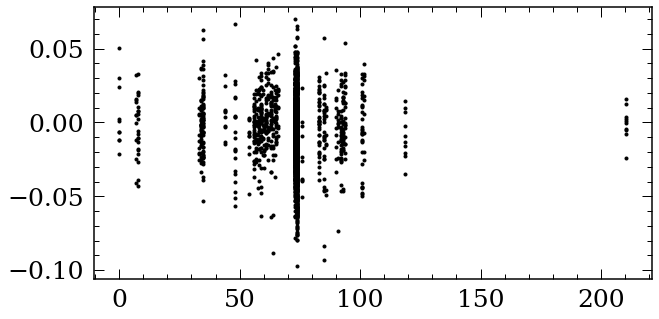

In [159]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(mainlc['mjd'],X[i,:],'k.')

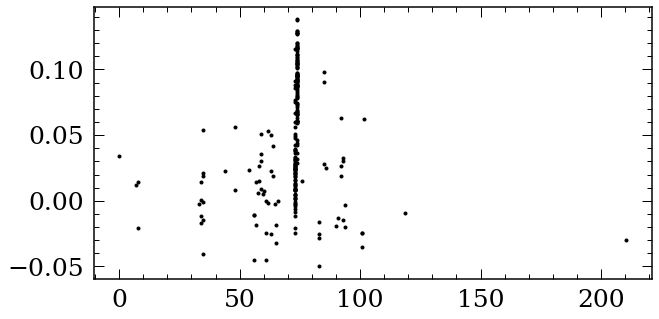

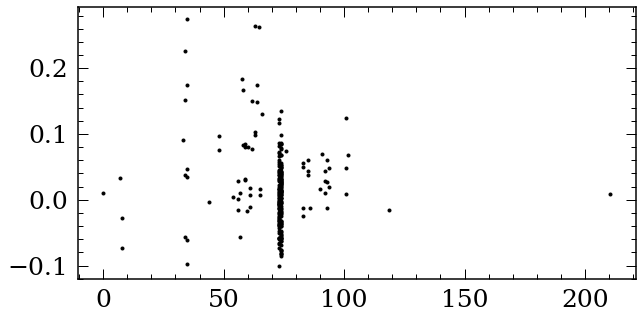

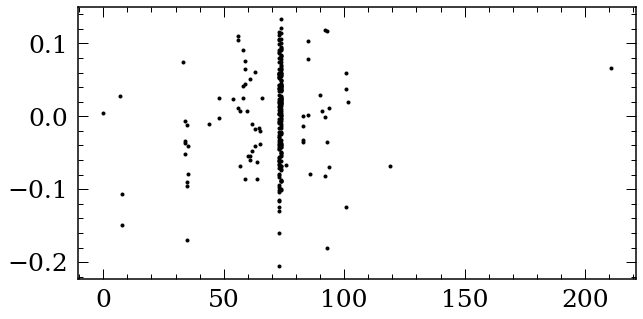

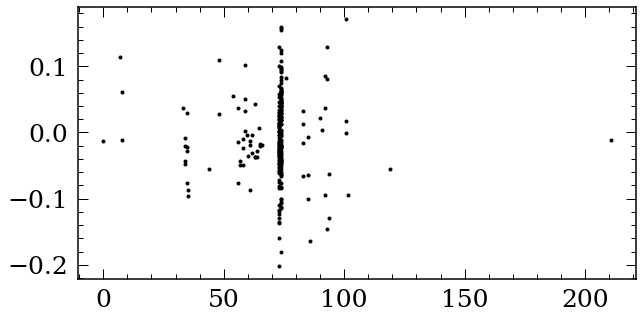

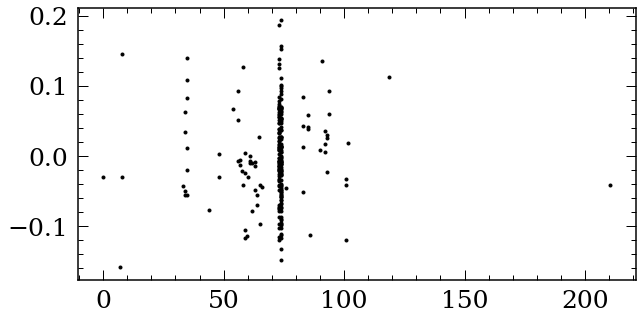

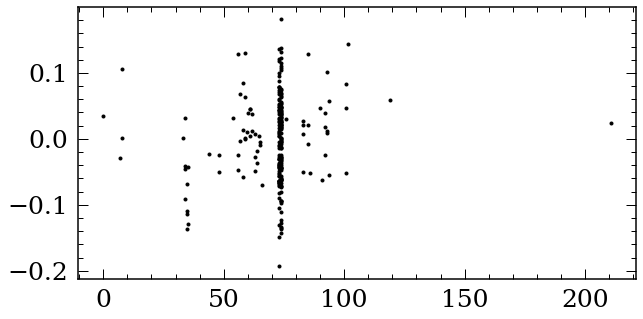

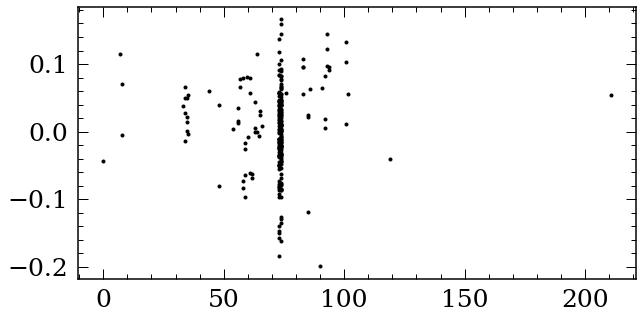

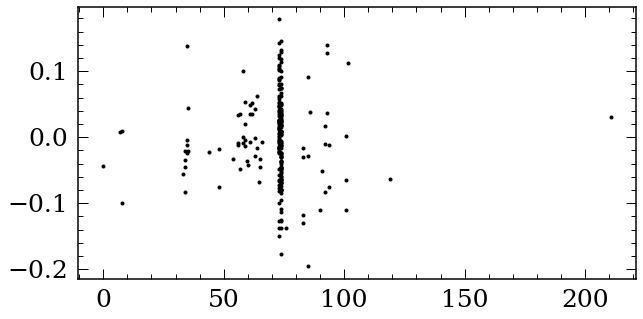

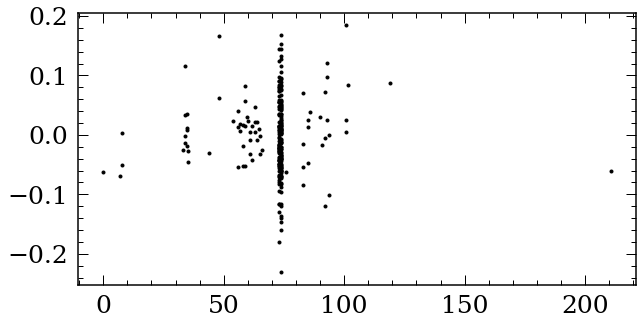

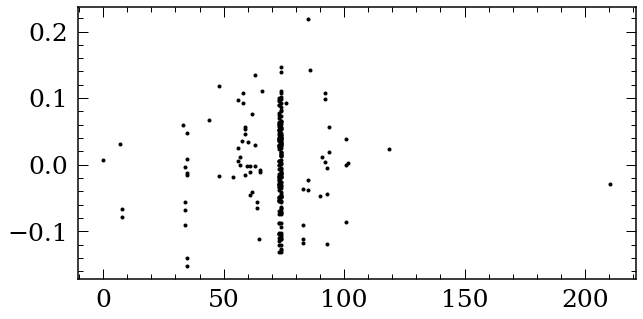

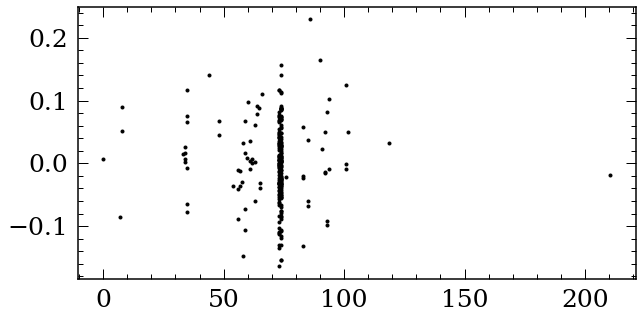

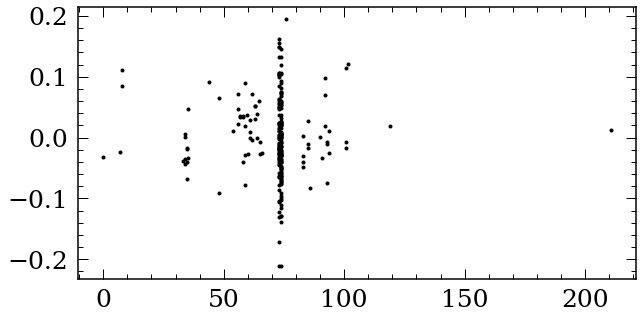

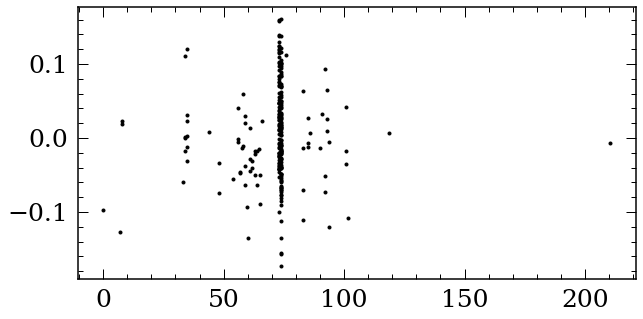

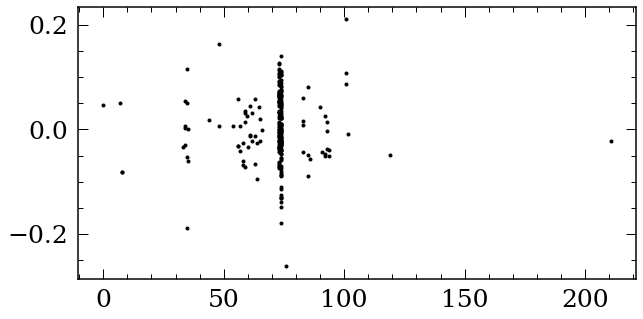

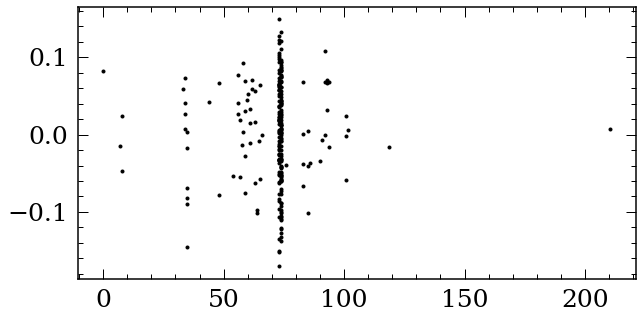

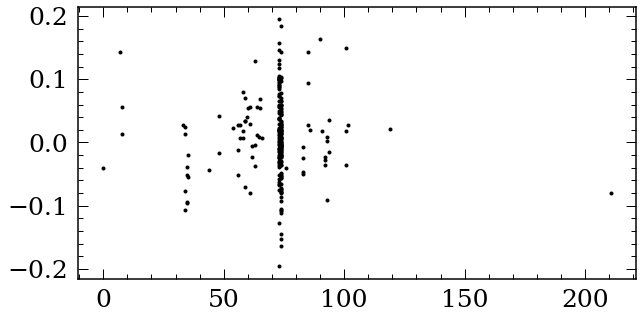

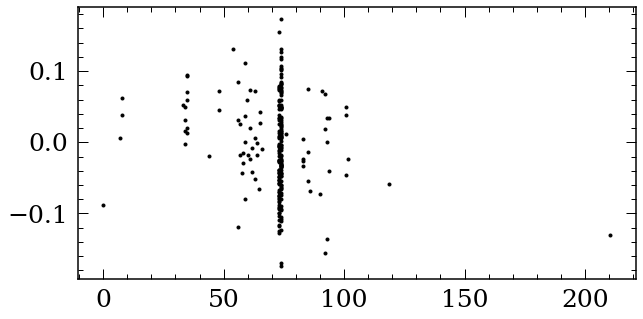

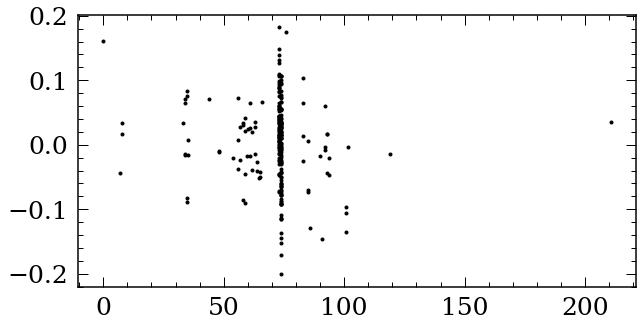

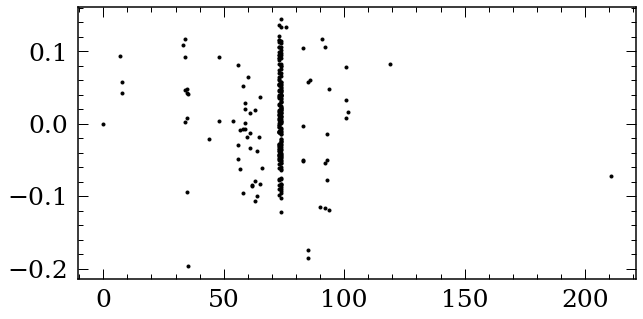

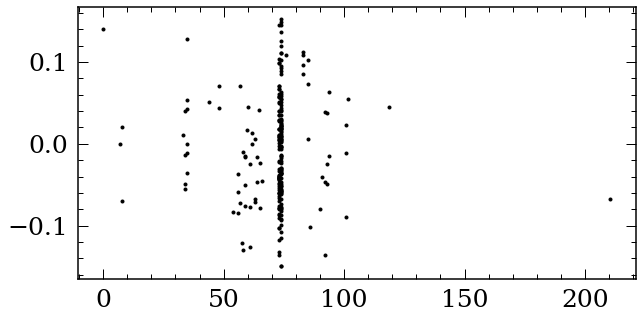

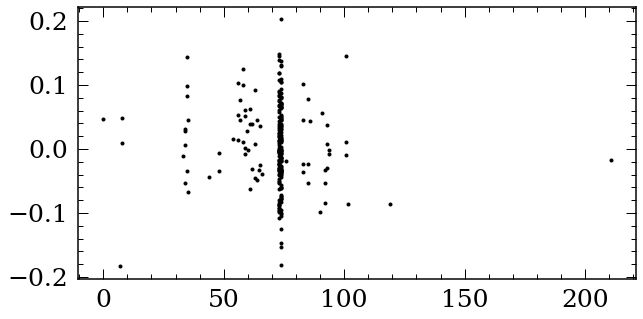

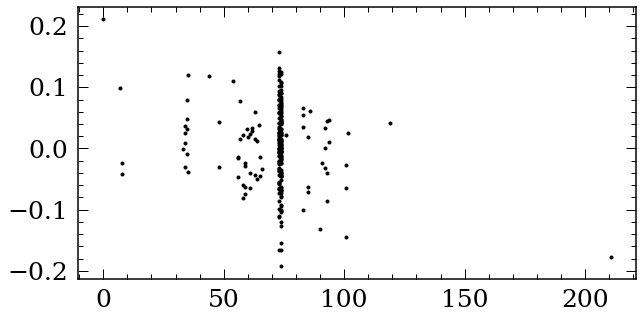

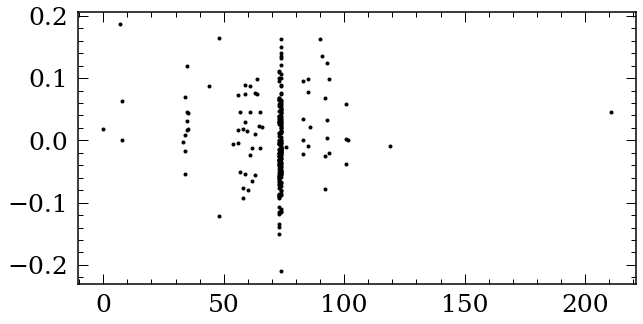

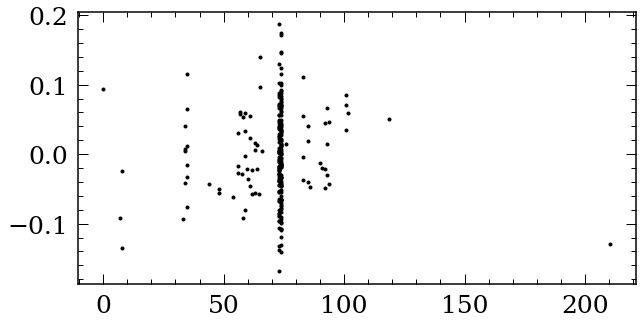

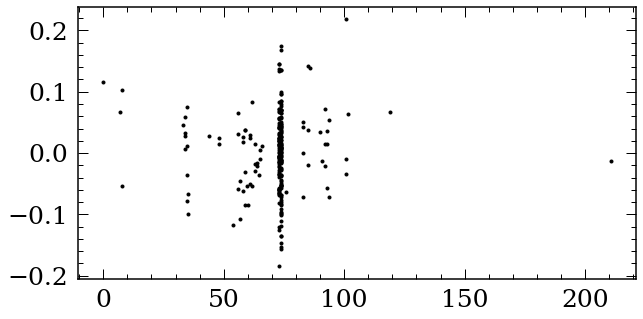

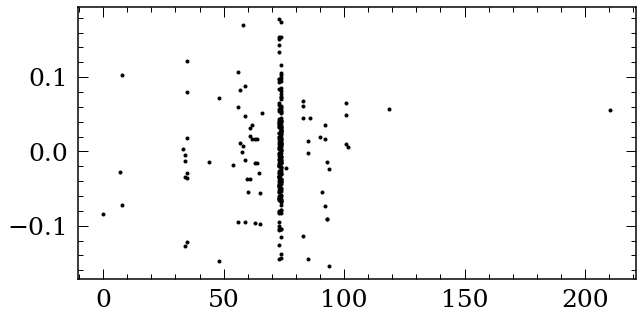

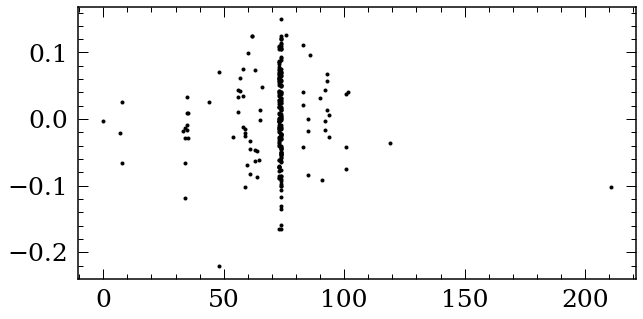

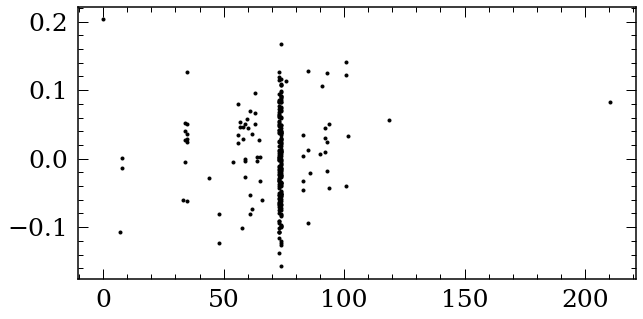

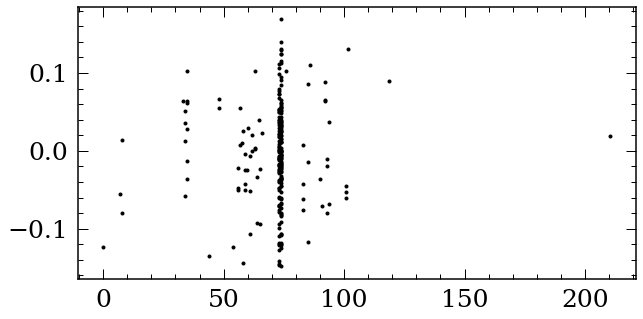

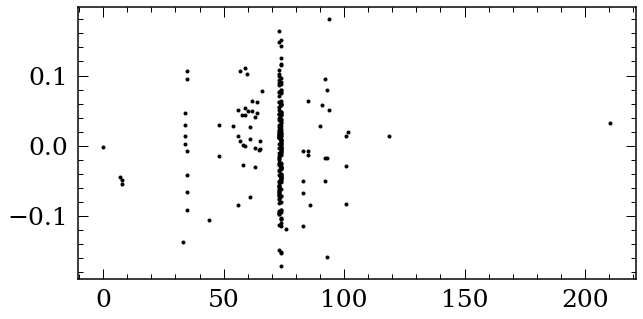

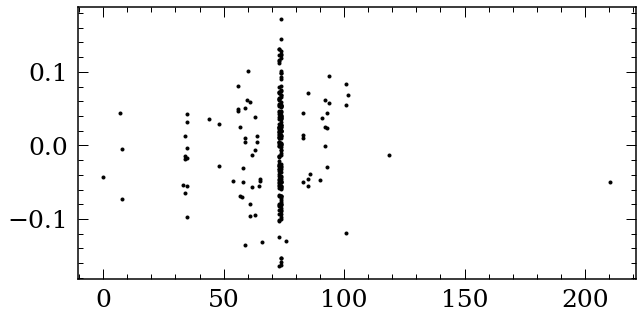

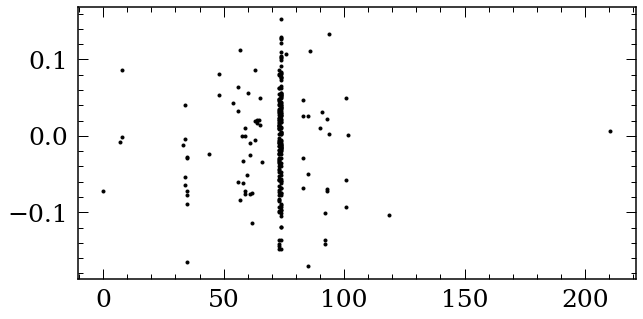

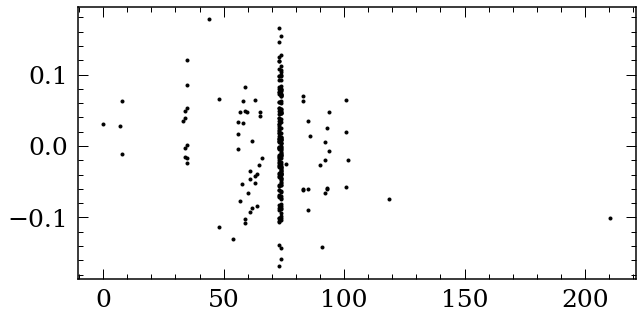

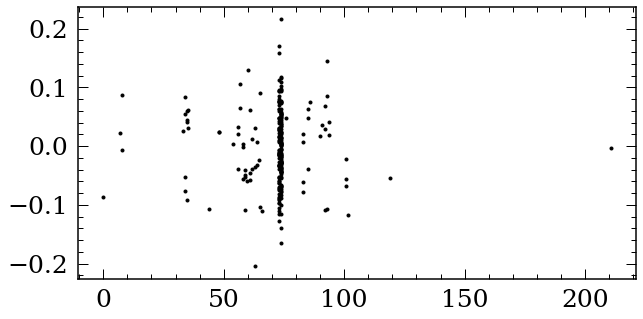

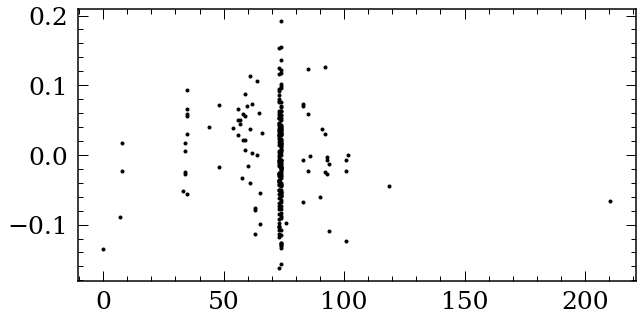

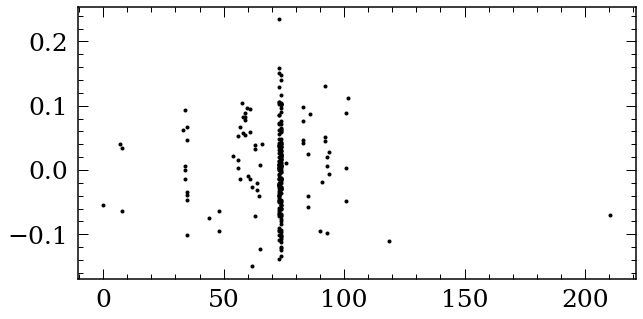

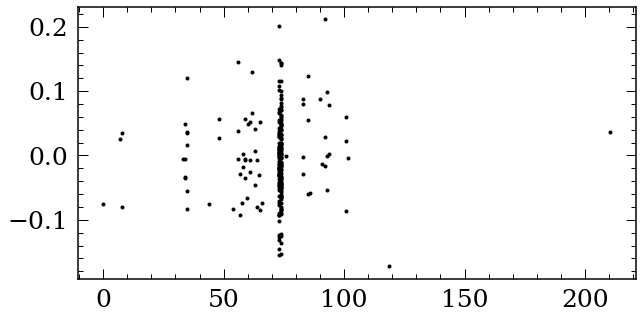

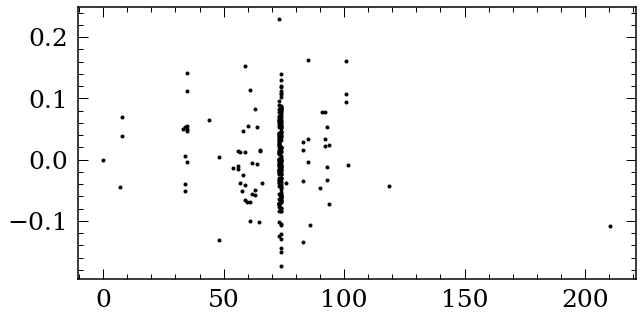

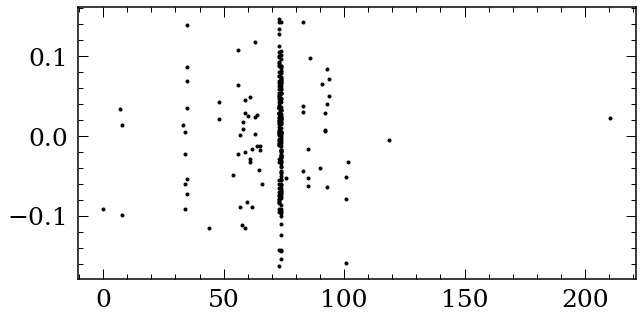

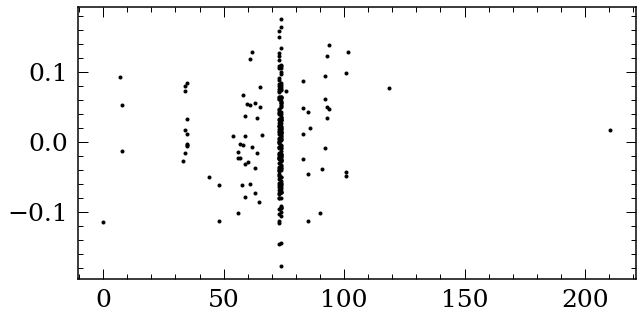

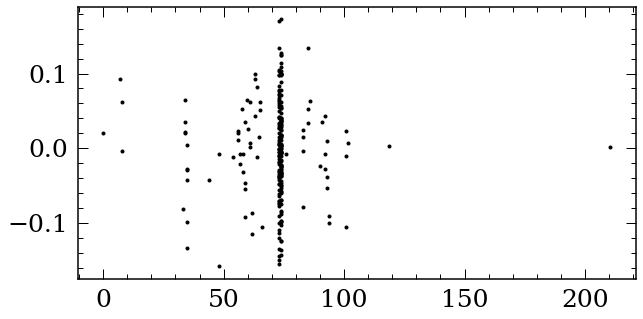

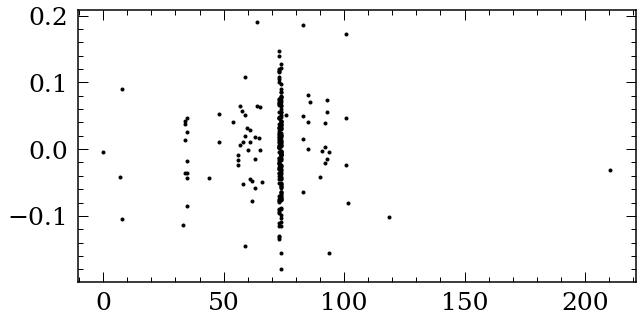

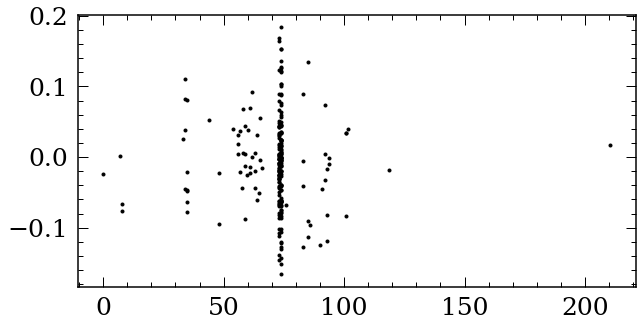

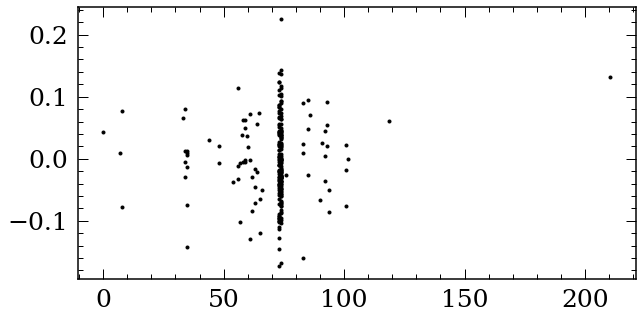

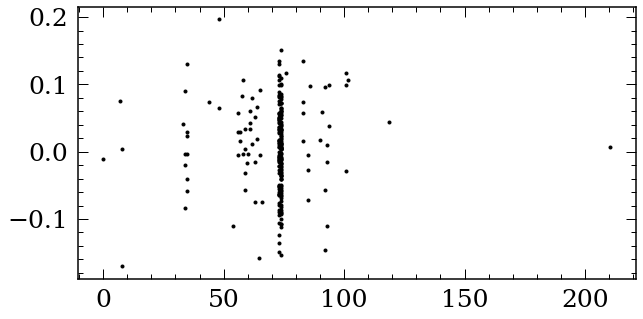

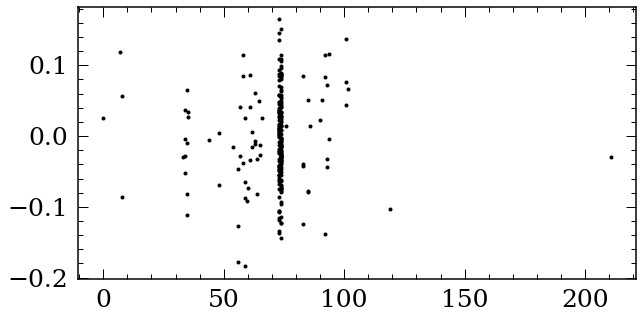

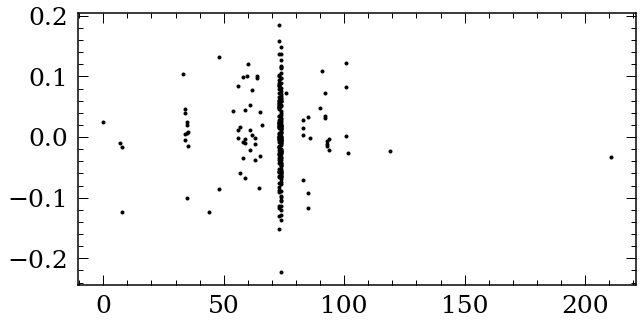

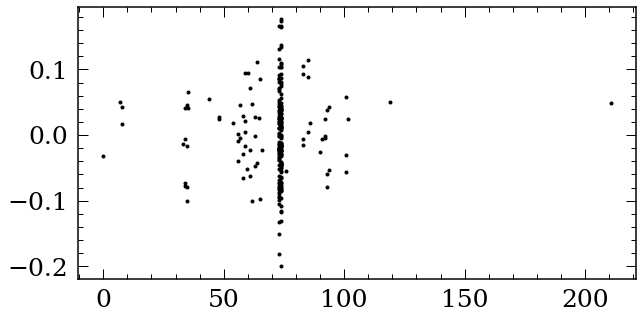

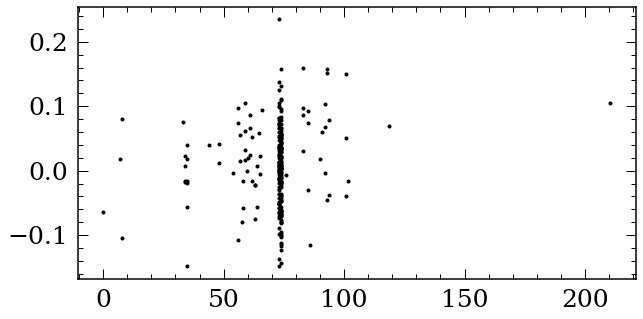

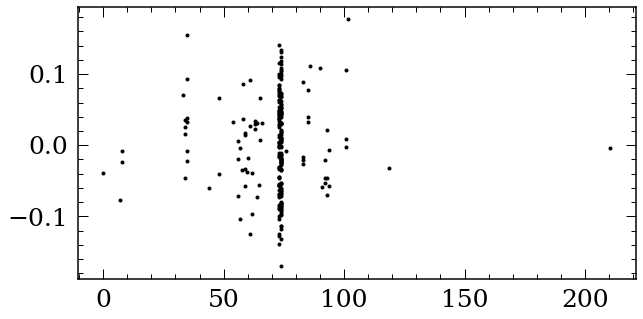

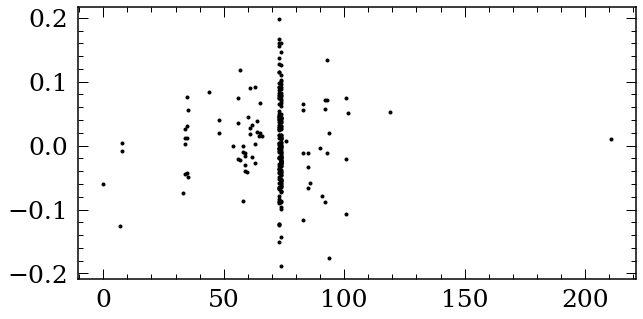

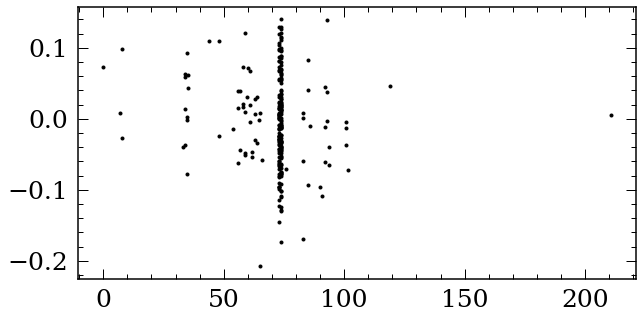

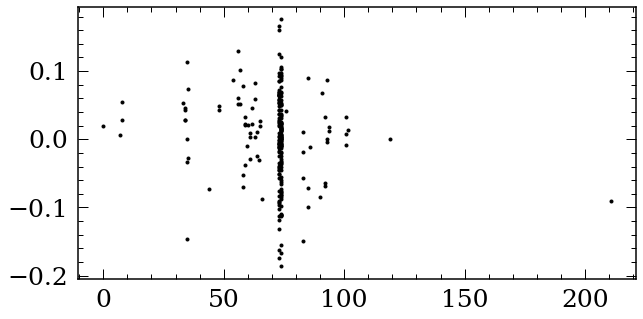

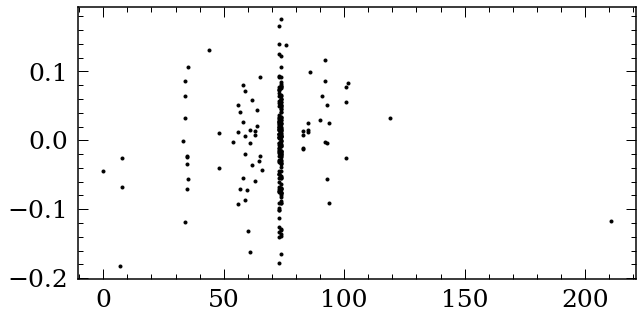

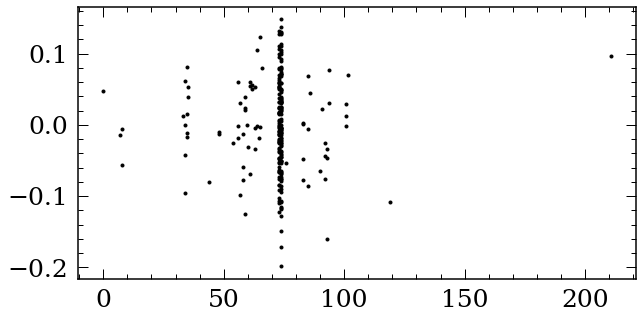

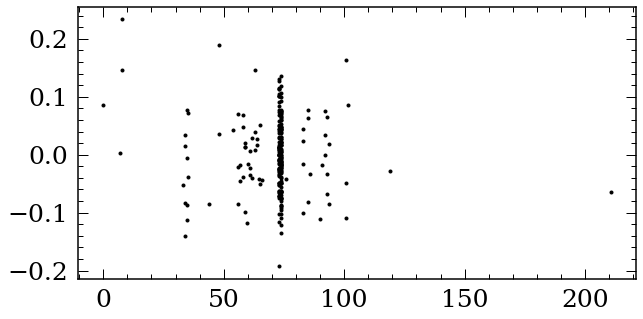

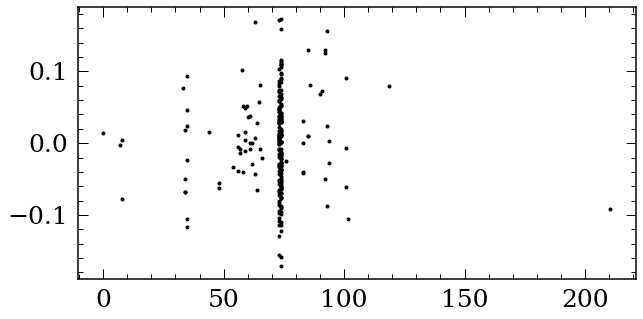

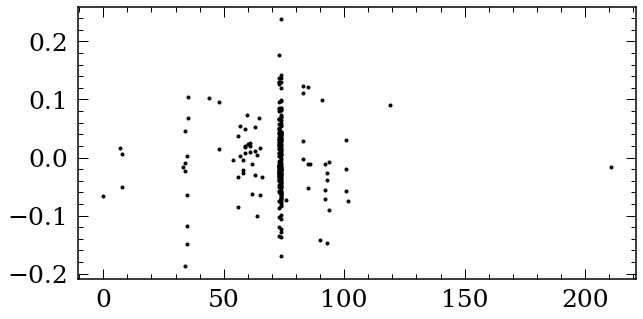

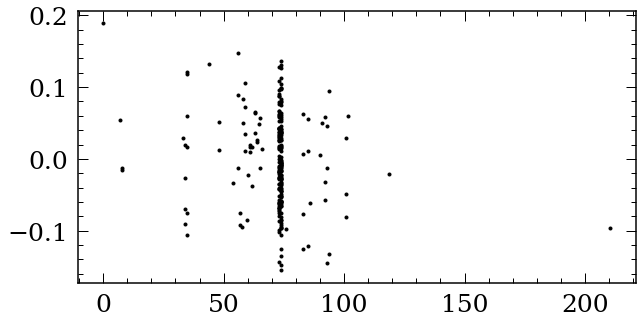

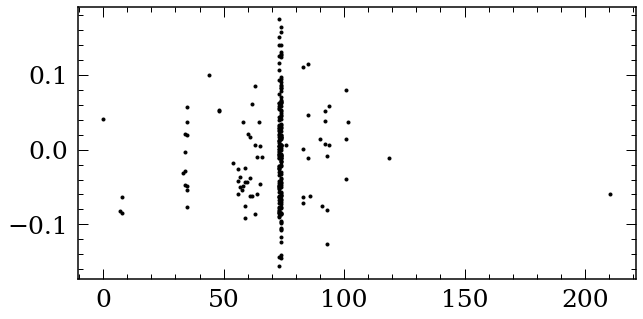

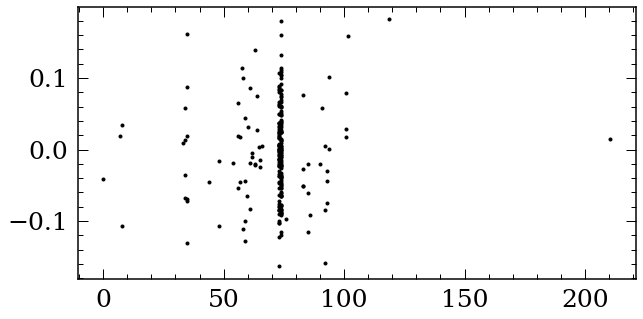

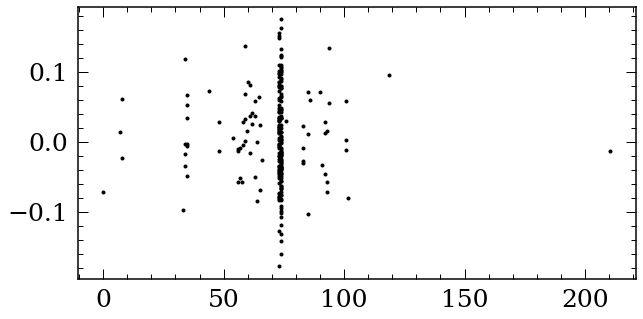

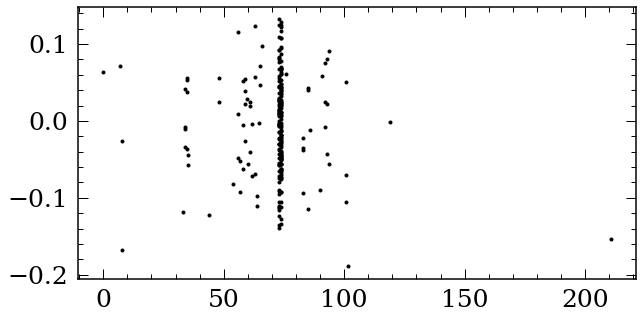

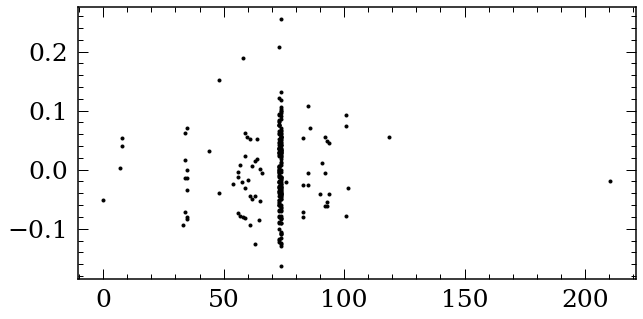

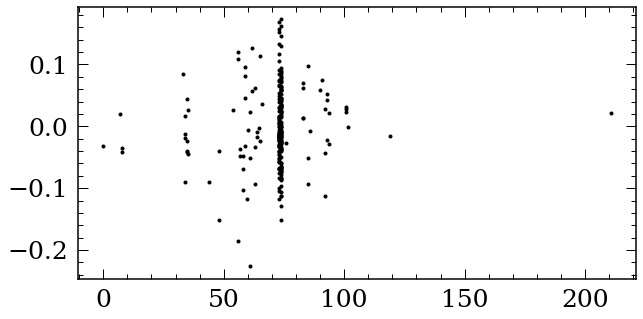

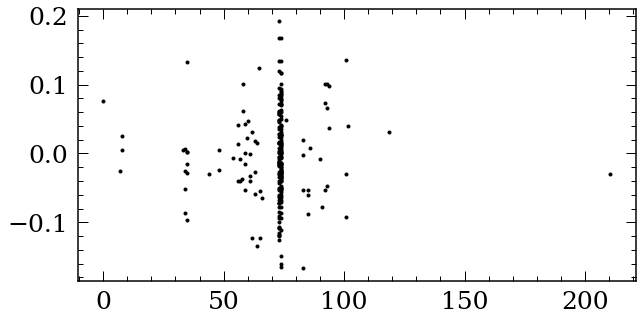

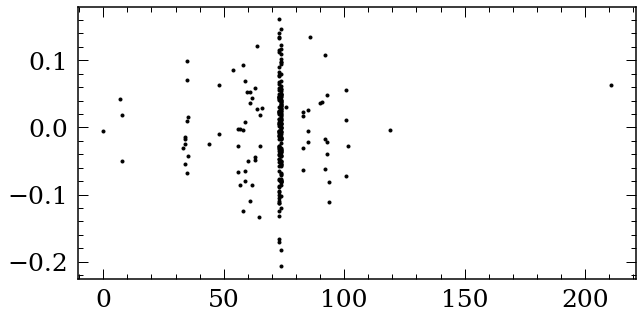

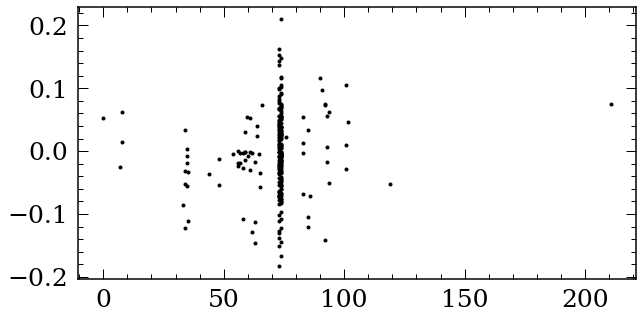

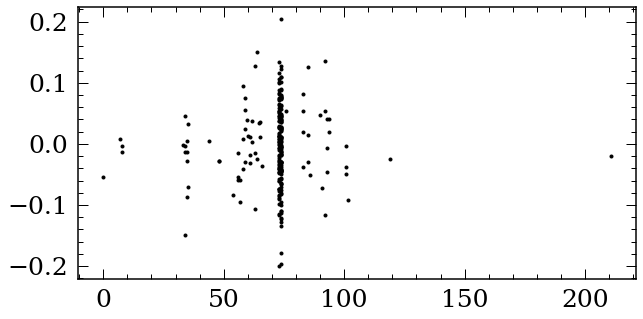

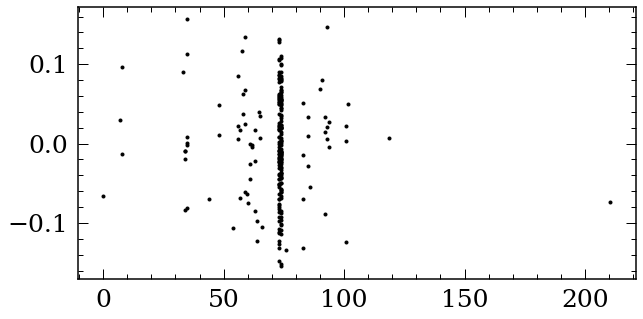

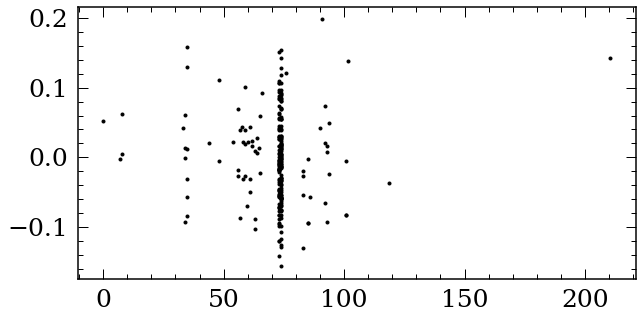

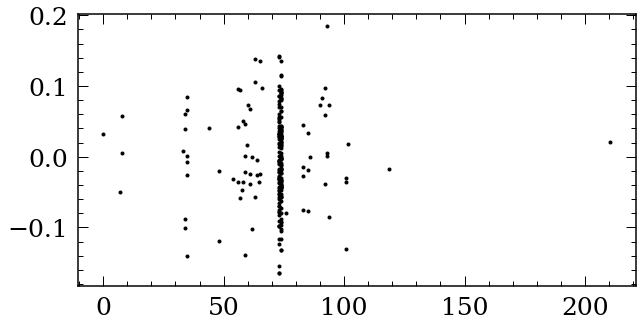

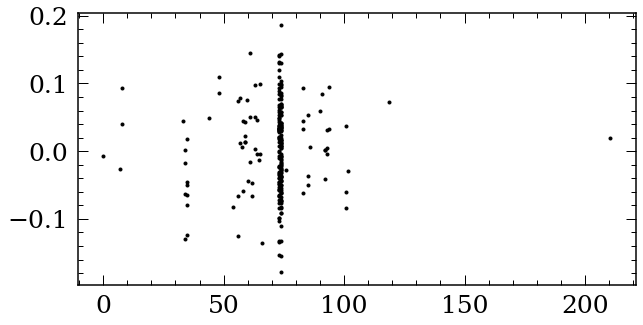

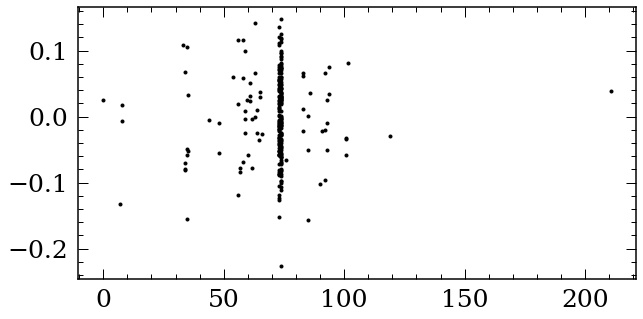

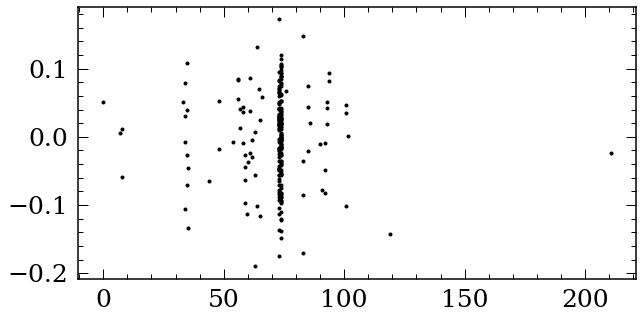

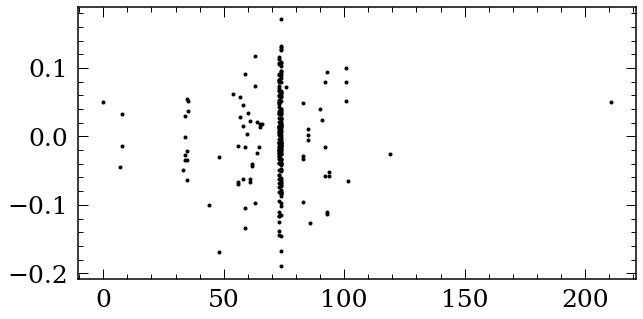

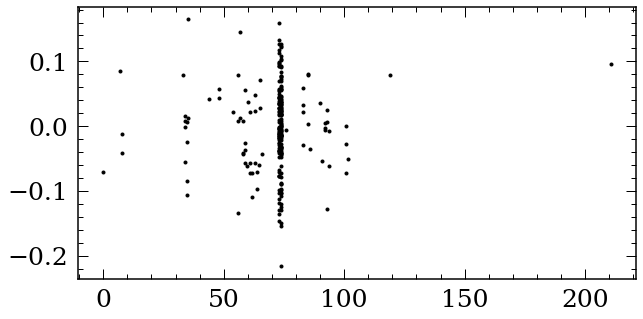

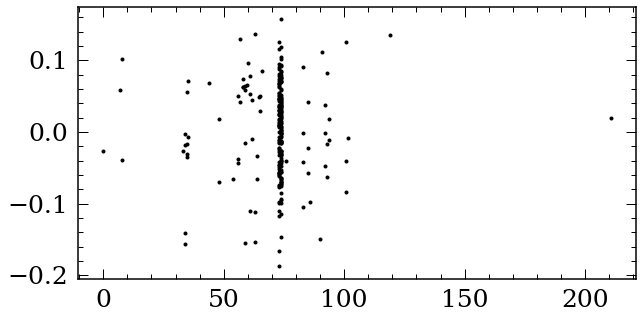

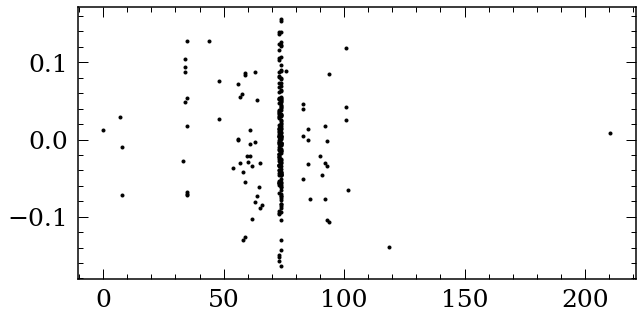

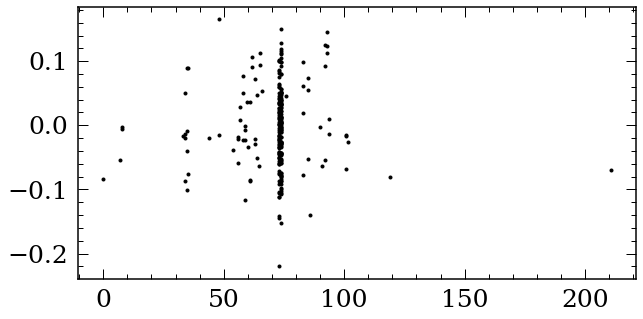

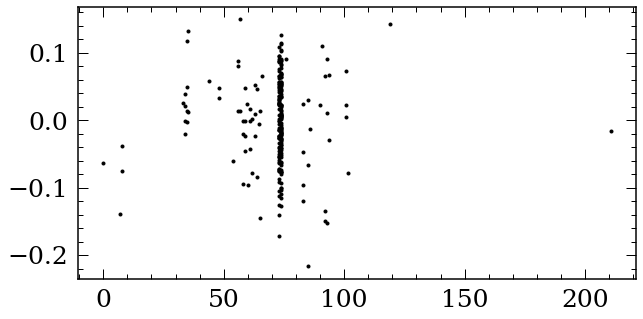

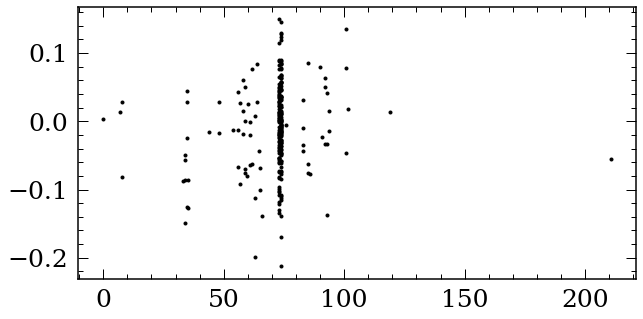

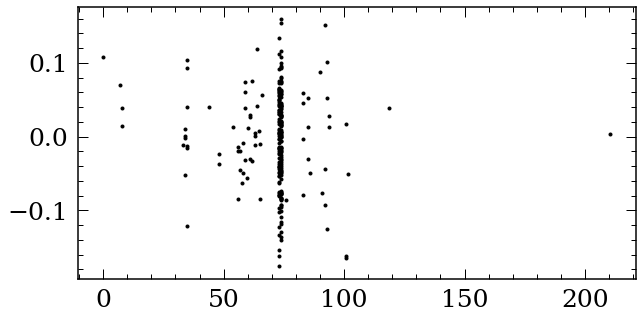

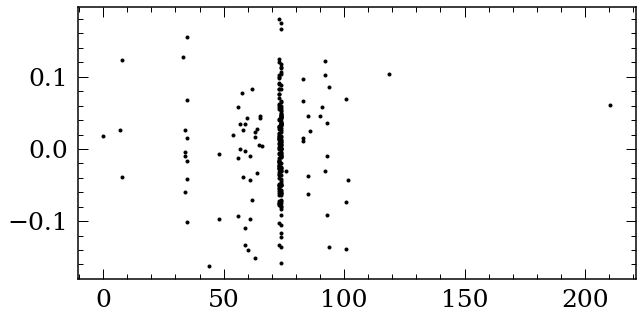

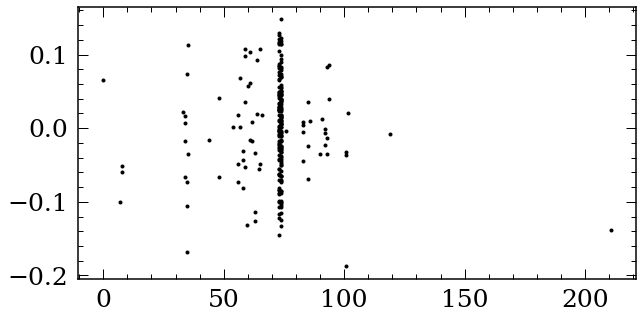

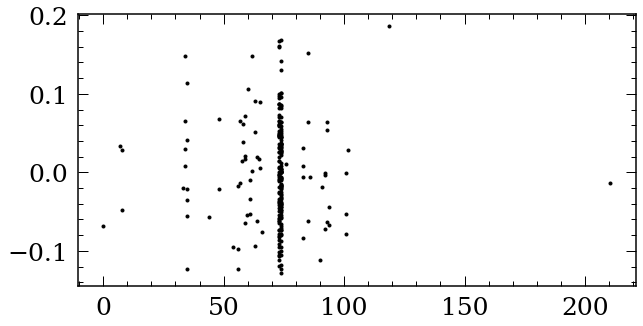

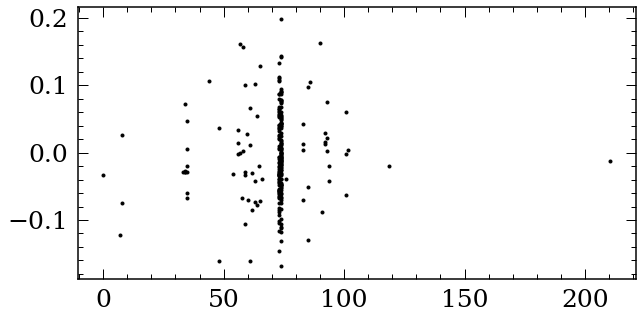

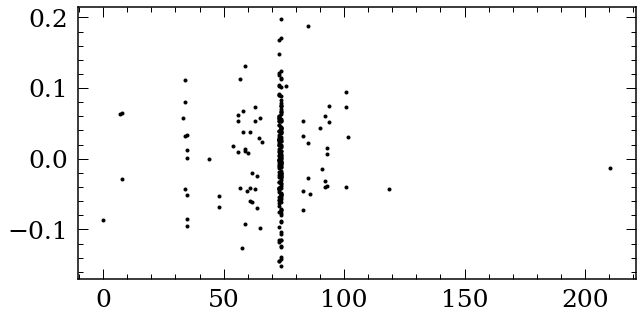

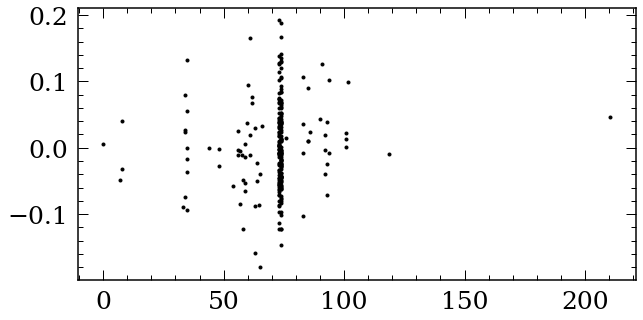

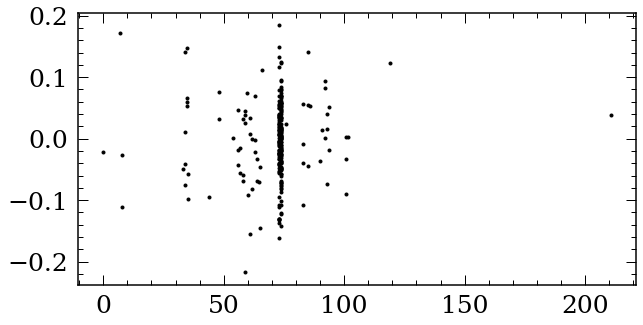

In [161]:
for i in range(90):
    plt.figure(figsize=(10,5))
    plt.plot(mainlc['mjd'],pca.components_[i,:],'k.')

